

# Dependencies



In [118]:

#!pip install h2o 
#!pip install joblib -U
#!pip install yellowbrick

import pandas as pd
import numpy as np
import sys
import h2o
from h2o.estimators import H2OKMeansEstimator
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans,MeanShift,AgglomerativeClustering
from sklearn.model_selection import train_test_split, ParameterGrid
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from joblib import dump, load
import itertools
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler,CondensedNearestNeighbour, NearMiss, EditedNearestNeighbours,RepeatedEditedNearestNeighbours,InstanceHardnessThreshold,NeighbourhoodCleaningRule,TomekLinks,ClusterCentroids,OneSidedSelection,AllKNN

# some colors for textual representation
class color:
   BLUE = '\033[94m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   END = '\033[0m'

In [119]:
import os
os.environ['JAVA_HOME'] = '/home/netmon/xsetin00/jdk-17'
os.environ['PATH'] = '/home/netmon/xsetin00/jdk-17/bin:' + os.environ['PATH']

print(os.environ['PATH'])

/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/home/netmon/xsetin00/jdk-17/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin


# Class definitions

## Dataset class

In [120]:
class Dataset():
  def __init__(self, path, label, use_case, class_values,to_drop=[]):
    self.path = path
    self.label = label
    self.use_case = use_case
    self.pos_value=class_values[0]
    self.neg_value=class_values[1]
    to_drop.append(label)
    self.to_drop=to_drop
  
  def new_classes(self,label):
    if label == self.pos_value:
        return 1
    else:
        return 0

  def load(self):
    self.csv_data=pd.read_csv(self.path)
    self.csv_data[self.label]=self.csv_data[self.label].apply(self.new_classes)
    return self.csv_data
  
  def set_data(self,data):
    self.csv_data=data

  def get_label(self):
    return self.csv_data[self.label][self.csv_data[self.label]==self.flag].reset_index(drop=True)

  def get_features(self):
    return self.csv_data[self.csv_data[self.label]==self.flag].drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)
  
  def get_all_label(self):
    return self.csv_data[self.label].reset_index(drop=True)

  def get_all_features(self):
    return self.csv_data.drop(columns=self.to_drop,errors="ignore").reset_index(drop=True)

  def set_class(self,flag):
    self.flag=flag
    self.y=self.get_label()
    self.X=self.get_features()
  
  def class_balance(self,data):
    pos=data[data==1].shape[0]
    neg=data.shape[0]-pos
    return {0:neg,1:pos,'all':data.shape[0]}

  def get_corr_analysis(self):
    correlation_with_class=self.csv_data.drop(columns=[self.label]).corrwith(self.csv_data[label],method="spearman").reset_index()
    correlation_with_class.columns=["atrr","corr"]
    
    corr_pos=correlation_with_class[correlation_with_class["corr"] >= 0.3]
    corr_neg=correlation_with_class[correlation_with_class["corr"] <= -0.3]

    self.class_corr=pd.concat([corr_pos,corr_neg],axis=0).reset_index(drop=True)
    #class_corr.to_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=False)
    return self.class_corr
    
  
  def get_corr_pairs(self):
    #self.class_corr=pd.read_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=None,names=["atrr","corr"])
    pos_corr=list(self.class_corr[self.class_corr["corr"]>0]["atrr"])
    neg_corr=list(self.class_corr[self.class_corr["corr"]<0]["atrr"])

    self.corr_pairs=list(itertools.product(pos_corr,neg_corr))+list(itertools.product(neg_corr,pos_corr))
    return self.corr_pairs
  
  def save(self,path):
      self.csv_data.to_csv(path,index=False)


class Modifier(Dataset):

  def __init__(self,new_path,label,use_case,class_values,to_drop=[]):
    super().__init__(new_path,label,use_case,class_values,to_drop)
    self.newdata=pd.DataFrame()
    self.improvement=0
  
  def update_csv(self):
    self.csv_data=self.newdata
    self.newdata=pd.DataFrame()

  def set_newdata(self,X=pd.DataFrame(),y=pd.DataFrame()):
    self.newdata=pd.concat([X,y],axis=1)


  def reduce(self,cluster_model,custom_ratio=None):
    self.set_class(cluster_model.class_number)
    cluster_model.data.set_class(cluster_model.class_number)
    reduction=cluster_model.reduction.array
    cluster_model.predict(self)
    reduction_data=cluster_model.result_new[cluster_model.result_new['predict'].isin(reduction)]
    no_reduction_data=cluster_model.result_new[~cluster_model.result_new['predict'].isin(reduction)]
    #print(reduction_data,no_reduction_data)

    for red_can in reduction:
      data_for_sample=reduction_data[reduction_data["predict"]==red_can]
      reduction_ratio=self.get_ratio(data_for_sample.shape[0],cluster_model.result_new.shape[0],cluster_model.size,)
      
      if reduction_ratio < 1:
        if custom_ratio is not None:
          if custom_ratio == 1/cluster_model.size:
            reduction_ratio=custom_ratio/(data_for_sample.shape[0]/cluster_model.result_new.shape[0])
          else: 
            reduction_ratio=custom_ratio
        sampled=data_for_sample.sample(frac=reduction_ratio,random_state=42)
        print("New ratio",sampled.shape[0]/cluster_model.result_new.shape[0]*100)
        no_reduction_data=pd.concat([no_reduction_data,sampled])
      else:
        no_reduction_data=pd.concat([no_reduction_data,data_for_sample])
      print("Reduction coef",reduction_ratio)
    index_reduction=no_reduction_data
    self.newdata=pd.concat([self.newdata,index_reduction.join(cluster_model.data.X).drop(columns=["predict"]).join(cluster_model.data.y)])

 
  def augument(self,cluster_model,custom_ratio=None):
    self.set_class(cluster_model.class_number)
    cluster_model.data.set_class(cluster_model.class_number)
    cluster_model.predict(self)
    new_data=cluster_model.result_new[cluster_model.result_new["predict"].isin(cluster_model.augument)]
    new_data_sampled=pd.DataFrame()
    for aug_can in cluster_model.augument.array:
      data_to_sample=new_data[new_data["predict"]==aug_can]
      ratio=self.get_ratio(data_to_sample.shape[0],cluster_model.result_new.shape[0],cluster_model.size)
      if custom_ratio is not None:
          if custom_ratio == 1/cluster_model.size:
            ratio=custom_ratio/(data_to_sample.shape[0]/cluster_model.result_new.shape[0])
          elif custom_ratio == 'all': 
            ratio=1
          else: ratio=custom_ratio
      #aug_size=int(data_to_sample.shape[0]*ratio)
      print("new ratio aug:",ratio)
      if ratio <= 1:
        data_to_sample=data_to_sample.sample(frac=ratio,random_state=42)
      else:
        data_to_sample=data_to_sample.sample(frac=1,random_state=42)
      new_data_sampled=pd.concat([new_data_sampled,data_to_sample])
    new_data_sampled=new_data_sampled.join(self.X)
    new_data_sampled=new_data_sampled.join(self.y)
    #new_data_sampled.pop("predict")
    print("new data sampled",cluster_model.class_number)
    print(new_data_sampled.shape)
    self.newdata=pd.concat([self.newdata,new_data_sampled])
    
  
  def get_ratio(self,cluster_data_size,whole_data_size,clusters_amount):
    cluster_ratio=cluster_data_size/whole_data_size*100
    print("K ratio",100/clusters_amount)
    print("Original ratio",cluster_ratio)
    cluster_avg=0.5*(cluster_ratio+100/clusters_amount)
    return cluster_avg/cluster_ratio
  
  def compare_models(self,old,new,test_data):
    
    X_train=self.newdata.drop(columns=self.label).reset_index(drop=True)
    y_train=self.newdata[self.label].reset_index(drop=True)
    new.fit(X_train,y_train)

    cnt_old=self.class_balance(self.get_all_label())
    self.cnt_new=self.class_balance(y_train)
    print("Old class balance",cnt_old)
    print("New class balance",self.cnt_new)
    print("Reduction ratio",100-self.cnt_new['all']/cnt_old['all']*100)
    X=test_data.get_all_features()
    y=test_data.get_all_label()

    pred_old = old.predict(X)
    print(classification_report(y,pred_old,digits=4))
    #total_acc=metrics.accuracy_score(y,pred_old)
    metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred_old) ).plot()
    plt.show()

    pred_new = new.predict(X)
    print(classification_report(y,pred_new,digits=4))
    #total_acc=metrics.accuracy_score(y,pred_new)
    metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred_new) ).plot()
    plt.show()
  

    # metrics.f1_score(y,pred_new,average="weighted")
    f1_old=metrics.f1_score(y,pred_old,average="weighted")
    f1_new=metrics.f1_score(y,pred_new,average="weighted")
    #print(f1_old,f1_new)
    space_to_improve=1-f1_old
    self.improvement=(f1_new-f1_old)/space_to_improve*100
    print("Improvement",self.improvement)

    return classification_report(y,pred_new,digits=4,output_dict=True)
  
  def apply_imbalanced_lib(self,sampler,prep=False):
    X_old=self.get_all_features()
    y_old=self.get_all_label()
    if prep:
        pipe=make_pipeline(StandardScaler(),VarianceThreshold())
        X_res, y_res = sampler.fit_resample(pipe.fit_transform(X_old), y_old)
        X_res=pipe.inverse_transform(X_res)
        X_res=pd.DataFrame(X_res, columns = X_old.columns)
    else:
        X_res, y_res = sampler.fit_resample(X_old, y_old)
        
    self.set_newdata(X_res, y_res)
  
  def prepare_model_result(self,report,method,dataset,metric='default'):
    #Methods OA Precision Recall F measure
    return pd.DataFrame({'Dataset':dataset, 'Method':method,'Metric':metric, 'Acc':report['accuracy'], 'Precision':report['weighted avg']['precision'], 'Recall':report['weighted avg']['recall'], 'F1':report['weighted avg']['f1-score'],"Impr":self.improvement,"Support_0":str(self.cnt_new[0]),"Support_1":str(self.cnt_new[1])},index=[0])

  def save_fig(self,y,pred,text):
    fig=metrics.ConfusionMatrixDisplay.from_predictions( y,pred).figure_
    fig.set_figwidth(8)
    fig.set_figheight(8)  
    fig.savefig(f"/content/drive/My Drive/Cluster/{self.use_case}/CM_{text}.png")

  
  

## Cluster class

In [121]:
class Cluster():
  
  def __init__(self):
    self.data=[]
    self.report={}

  def add_data(self,row):
    self.data.append(row)

  def data_to_df(self,columns):
    self.dataframe=pd.DataFrame(self.data,columns=columns)
    ######print(self.dataframe)

  def classify_cluster(self,classifier,label):
    pred = classifier.predict(self.dataframe)
    y_gen = label.repeat(self.dataframe.shape[0])
    ######print(classification_report(y_gen, pred))
    ######print(metrics.confusion_matrix(y_gen, pred))
    self.report["acc"]=metrics.accuracy_score(y_gen,pred)
    #metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) ).plot();
  
  def variance(self):
    ######print(color.BOLD +color.BLUE+'\nVariance of features:'+ color.END)
    ######print(self.dataframe.var().sort_values().to_string())
    pass
  
  def get_mean(self,original_mean):
    ######print(color.BOLD +color.BLUE+'\nAverage of features:'+ color.END)
    self.mean=self.dataframe.mean()
    out=self.mean.sort_values()
    ######print(out.to_string())
  
  def diff(self,original_mean,min,max):
    # average deviation of features
    diff=self.mean-original_mean
    # get maximal difference
    lower_min=abs(original_mean-min)
    lower_max=abs(original_mean-max)

    for i,value in diff.iteritems():
      if value == 0:
        diff.at[i]=0
      else:
        if value < 0:
            diff.at[i]=value/lower_min[i]*100
        else:
            diff.at[i]=value/lower_max[i]*100

    ######print(color.BOLD +color.BLUE+'\nAverage deviation of features (%):'+ color.END)
    diff = diff.sort_values().dropna()
    out=diff
    ######print(out.to_string())
    self.report["dev"]=out

  def get_diff(self):
    return self.report["dev"]
  
  def correlation(self):
    ######print(color.BOLD +color.BLUE+'\nCorrelation of features:'+ color.END)
    pairs_to_drop = set()
    cols = self.dataframe.columns
    for i in range(0, self.dataframe.shape[1]):
      for j in range(0, i+1):
        pairs_to_drop.add((cols[i], cols[j]))
    out=self.dataframe.corr(method='spearman').unstack().drop(labels=pairs_to_drop).sort_values().dropna()
    ######print(out.to_string())
    self.report["corr"]=out
  
  def size(self):
    ######print(color.BOLD + color.BLUE+'\nSize of cluster:'+ color.END)
    self.report["size"]=self.dataframe.shape[0]
    ######print(self.dataframe.shape[0],'\n')
  
  def inv_amount(self,original_size):
    self.amount_ratio=self.report["size"]/original_size*100
    self.inv_amount_ratio=100-self.amount_ratio
    print("inv_amount ratio",self.inv_amount_ratio)
    print("amount ratio",self.amount_ratio)
    
  def diff_deviation(self):
    self.extreme_deviation=self.report["dev"][lambda x: (x < -50) | (x > 50)]
    # if self.extreme_deviation.empty:
    #   self.mean_deviation=0
    # else:
    #   abs_dev=self.extreme_deviation.abs()
    self.mean_deviation=self.report["dev"].abs().mean()
    
    ######print("average deviation",self.mean_deviation)

    extreme_deviation_cnt=len(self.extreme_deviation)
    self.ratio_extreme_deviation=extreme_deviation_cnt/len(self.report["dev"])*100
    
    ######print("ratio of extreme deviation",self.ratio_extreme_deviation)
    #cluster_dev.append(extreme_deviation_cnt)
    
  def adversial(self,data):
    corr_pos=self.report["corr"][lambda x: x >= 0.75]
    corr_neg=self.report["corr"][lambda x: x <= -0.3]
    self.adversial_distance=0
    corr_cnt=0
    if not corr_neg.empty:
      #print(corr_neg)
      for corr in corr_neg.index:
        if corr in data.corr_pairs:
          corr_cnt+=1
          #print(corr)
          first = corr[0]
          second = corr[1]
          #print(first,second)
          self.adversial_distance+=abs(self.report["dev"][first]-self.report["dev"][second])
      if corr_cnt != 0:
        self.adversial_distance/=corr_cnt*2
        self.adversial_distance=100-self.adversial_distance
    
    ######print("adversarial distance",self.adversial_distance)
  
  def similarity(self,data):
    neg_attr=list(data.class_corr[data.class_corr["corr"]<0]["atrr"])
    pos_attr=list(data.class_corr[data.class_corr["corr"]>0]["atrr"])
    #print(neg_attr,pos_attr)
    sim_neg=0
    sim_pos=0

    for attr in neg_attr:
      sim_neg+=self.report["dev"][attr]
    if len(neg_attr) != 0:
      sim_neg=(sim_neg/len(neg_attr)+100)/2
    
    
    for attr in pos_attr:
        sim_pos+=self.report["dev"][attr]
    if len(pos_attr) != 0:
      sim_pos=(sim_pos/len(pos_attr)+100)/2
    

    if data.flag:
      sim_pos=100-sim_pos
    else:
      sim_neg=100-sim_neg
    self.sim=(sim_neg+sim_pos)/2
    ######print("similarity",self.sim) 

  def acc_deviation(self,total_acc,min_acc,max_acc):
    relative_deviation_acc=self.report["acc"]-total_acc

    if relative_deviation_acc == 0:
      self.acc_ratio=50
    else:
      if relative_deviation_acc < 0:
          self.acc_ratio=((relative_deviation_acc/abs(min_acc-total_acc)*(-100))+100)/2
      else:
          self.acc_ratio=((relative_deviation_acc/abs(max_acc-total_acc)*(-100))+100)/2
    
    ######print("relative deviation of model acc",self.acc_ratio,relative_deviation_acc,total_acc,self.report["acc"])
    #acc_dev.append(self.acc_ratio)
  
  def get_score(self):
    self.score=(self.mean_deviation+self.ratio_extreme_deviation+self.adversial_distance+self.inv_amount_ratio+self.sim+self.acc_ratio)/6
    ######print("FINAL",self.score,"\n")
    return self.score

  def red_candidate(self,red_tr,aug_tr):
    if self.amount_ratio > red_tr and self.score < aug_tr:
      self.report['red']=1
      ######print("reduction candidate",self.amount_ratio,red_tr)
    else:
      self.report['red']=0

## Model classes

In [122]:
from abc import ABC, abstractmethod

class Model(ABC):
 
  def __init__(self):
    self.result=None
    self.size=0
    self.data=None
    self.clusters={}
    self.classifier=None
    self.score=[]
  
  @abstractmethod
  def train(self):
    pass
  
  @abstractmethod
  def predict(self,data):
    pass

  @abstractmethod
  def perf(self):
    pass

  @abstractmethod
  def load(self):
    pass

  @abstractmethod
  def save(self):
    pass

  def divide_data(self):
  
    # init dictionary for individual clusters
    for x in range(0,self.size):
      self.clusters[f'cluster{x}']=Cluster()
      #self.report[f'cluster{x}']={}

    # insert clustered data to predicted cluster
    for i,row in enumerate(self.data.X.to_numpy()):
      self.clusters[f'cluster{self.result.values[i][0]}'].add_data(row)

  def dataset_acc(self):
    pred=self.classifier.predict(self.data.X)
    ######print(classification_report(self.data.y,pred))#Data["is_doh"], pred))
    self.total_acc=metrics.accuracy_score(self.data.y,pred)
    ######metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(self.data.y, pred) ).plot();
    plt.show()
    return self.total_acc

  def statistical_report(self):
    s = pd.Series([self.data.flag])
    original_mean=self.data.X.mean()
    original_min=self.data.X.min()
    original_max=self.data.X.max()
   
    self.data.get_corr_analysis()
    self.data.get_corr_pairs()
    

    for cluster in self.clusters:
      # number of cluster
      ######print(color.BOLD + color.RED+ cluster+ color.END)

      # dataframe for effective metrics computation
      self.clusters[cluster].data_to_df(self.data.X.columns)
      
      # classify cluster
      self.clusters[cluster].classify_cluster(self.classifier,s)

      # variance of features
      self.clusters[cluster].variance()
    
      # average of features
      self.clusters[cluster].get_mean(original_mean)
      
      #difference of features
      self.clusters[cluster].diff(original_mean,original_min,original_max)
      
      # correlation of features
      self.clusters[cluster].correlation()

      # size of cluster
      self.clusters[cluster].size()
  
  def compute_score(self):
    accs=list(map(lambda x: x[1].report["acc"],list(self.clusters.items())))
    max_acc=max(accs)
    min_acc=min(accs)
    self.score=[]
    self.amount=[]
    #print(self.report['cluster0']["dev"])
    for cluster in self.clusters:

      ######print(cluster)    
      # amount of data in cluster
      self.clusters[cluster].inv_amount(self.data.X.shape[0])

      # pick up most deviated clusters 
      self.clusters[cluster].diff_deviation()
      
      # check if negativly correlated attrr are adversarial
      self.clusters[cluster].adversial(self.data)
      
      #similarity to another class
      self.clusters[cluster].similarity(self.data)

      # acc deviation
      self.clusters[cluster].acc_deviation(self.total_acc,min_acc,max_acc)
      
      # make one metrics, always percenatge, complement of acc, maybe normalize to 0,1 by averaging
      self.score.append(self.clusters[cluster].get_score())
      self.amount.append(self.clusters[cluster].amount_ratio)
      
    self.score_data=self.get_results()

  def get_results(self):
    
    acc_dev=[]
    amount=[]
    red=[]
    cluster_num=[]
    heatmap=pd.DataFrame()

    temp=pd.Series(self.amount)
    #self.reduction_threshold=100/self.size*1.8
    self.reduction_threshold=(100/self.size+2*temp.max())/3
    temp=pd.Series(self.score)
    self.aug_threshold=(2*temp.mean()+temp.max())/3

    for cluster in self.clusters:
      # reduction candidate
      self.clusters[cluster].red_candidate(self.reduction_threshold,self.aug_threshold)
      amount.append( self.clusters[cluster].amount_ratio)
      red.append(self.clusters[cluster].report['red'])
      acc_dev.append(self.clusters[cluster].acc_ratio)
      cluster_num.append(cluster)
      heatmap=pd.concat([heatmap,self.clusters[cluster].get_diff().rename(cluster)],axis=1)

    print("AUG THRESHOLD",self.aug_threshold)
    print("RED THRESHOLD",self.reduction_threshold)
    return pd.DataFrame({"skore":self.score,"podil dat":amount,"redukce":red,"inv_acc":acc_dev})
    
  def plot_results(self):
    ax=self.score_data.plot.bar(figsize=(9,7))
    ax.set(xlabel='Shluky', ylabel='Hodnota (%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    fig=ax.get_figure()
    plt.show()
    plt.clf()
    ax=sns.regplot(x="skore",y="inv_acc",data=self.score_data,ci=None)
    plt.show()
    # fig.savefig(f"/content/drive/My Drive/Cluster/score_chart_{label}_{flag}.pdf")
  
  def save_report(self):
    self.augument=self.score_data[self.score_data["skore"]>self.aug_threshold].reset_index()["index"]
    self.augument=self.augument.rename("augument")
    self.reduction= self.score_data[self.score_data["redukce"]==1].reset_index()["index"]
    self.reduction = self.reduction.rename("reduction")

    #augument.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False)
    #reduction.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False,mode="a")
    print(self.augument,"--\n",self.reduction)
  
  def cluster_analysis(self,pca=False):
    if pca:
      self.prep=make_pipeline(StandardScaler(),VarianceThreshold(),PCA(n_components='mle'))
    else:
      self.prep=make_pipeline(StandardScaler(),VarianceThreshold())
    self.pca=pca
    self.train()
    self.perf()
    self.divide_data()
    self.dataset_acc()
    self.statistical_report()
    self.compute_score()
    self.plot_results()
    self.save_report()

class H2O_model(Model):

  def __init__(self, data, classifier,class_number):
    super().__init__()
    self.data=data
    self.classifier=classifier
    self.class_number=class_number
    self.data.set_class(class_number)
    
    
    # model inicializaton
    h2o.init()
    self.model=H2OKMeansEstimator( k=10,
                              estimate_k=True,
                              standardize=False,
                              seed=1234,
                              max_iterations = 100)
  def train(self):
    # create h2o data frame
  
    inner_data = h2o.H2OFrame(self.prep.fit_transform(self.data.X))
    
    # create model for kmeans algorithm
    self.model.train(training_frame=inner_data)

    self.size=len(self.model.size())

    tmp=self.model.predict(inner_data)
    self.result=tmp.as_data_frame(use_pandas=True, header=True)
  
  def predict(self,data):
  
    h2o_frame=h2o.H2OFrame(self.prep.fit_transform(data.X))
    tmp=self.model.predict(h2o_frame)
    self.result_new=tmp.as_data_frame(use_pandas=True, header=True)
   

  def perf(self):
    # show some model metrics
    print(self.model.model_performance())
  
  def save(self):
    h2o.save_model(model=self.model, path=f"/content/drive/My Drive/Cluster/{self.data.use_case}", force=True)
  
  def load(self):
    self.model=h2o.load_model(f"/content/drive/My Drive/Cluster/{self.data.use_case}/kmeans_model")

class Sklearn_model(Model):

  def __init__(self, data, classifier,class_number,model='kmeans',index='bouldin'):
    super().__init__()
    self.data=data
    self.classifier=classifier
    self.class_number=class_number
    self.data.set_class(class_number)
    self.model_name=model
    self.max_k=10
    self.optimal_ks={}
    self.index=index
    self.criterion =min(0.02 + 10. / self.data.X.shape[0] + 2.5 / pow(self.data.X.shape[1], 2), 0.8)

    if self.model_name == 'kmeans':
      self.models=[KMeans(n_clusters=i,max_iter=100,random_state=42) for i in range(1,self.max_k+1)]
    elif self.model_name == 'mean_shift':
       self.models=[MeanShift()]
    elif self.model_name == 'aglomerative':
       self.models=[AgglomerativeClustering(n_clusters=i, linkage="ward") for i in range(1,self.max_k+1)]

    # model inicializaton

  def visualize(self):
    #metrics=['calinski_harabasz','silhouette','elbow']
  
    model = KMeans(max_iter=100,random_state=42)
    # k is range of number of clusters.
    if self.index == 'elbow':
      visualizer = KElbowVisualizer(model, k=(2,10), timings= True)
    else:
      visualizer = KElbowVisualizer(model, k=(2,10) ,metric=self.index, timings= True)
    visualizer.fit(self.prep.fit_transform(self.data.X))        # Fit the data to the visualizer
    visualizer.show()  
    self.optimal_ks[self.index]=visualizer.elbow_value_
    plt.show()
    plt.style.use('default')

  def pre(self):
    models=[KMeans(n_clusters=i,max_iter=100,random_state=42) for i in range(1,self.max_k+1)]
    model_old = models[0]
    model_old.fit(self.prep_data)
   
    
    distorsions = []
    bouldin_score=[]
    if self.index=='PRE':
        print("CRIT",self.criterion)
        distorsions.append(model_old.inertia_)
        print("SSE",model_old.inertia_)
    k=2
    for model in models[1:]:
        model.fit(self.prep_data)
        bouldin_score.append(davies_bouldin_score(self.prep_data, model.labels_))
        if self.index=='PRE':
          distorsions.append(model.inertia_)
          print("SSE",model.inertia_)
          PRE=(distorsions[k-2]-distorsions[k-1])/distorsions[k-2]
          print("PRE",PRE,k)
          k+=1
          if PRE < self.criterion:
            break
        model_old=model
    
    sorted=bouldin_score.copy()
    sorted.sort()
    self.optimal_ks['bouldin']=bouldin_score.index(sorted[0])+2
    if self.optimal_ks['bouldin'] == 2:
      self.optimal_ks['bouldin']=bouldin_score.index(sorted[1])+2

    if self.index=='PRE':
        self.optimal_ks['PRE']=len(np.unique(model_old.labels_)) 
        fig = plt.figure(figsize=(15, 5))
        plt.plot(range(1, len(distorsions)+1), distorsions)
        plt.grid(True)
        plt.title('Elbow curve')
        plt.show()
    else:
        plt.plot(range(2, len(bouldin_score)+2), bouldin_score, linestyle='--', marker='o', color='b');
        plt.xlabel('K');
        plt.ylabel('Davies Bouldin score');
        plt.title('Davies Bouldin score vs. K');
        plt.show()

  def estimate_k(self):
    if self.index in ['PRE','bouldin']:
      self.pre()
    else:
      self.visualize()
    
    self.size=self.optimal_ks[self.index]

  def train(self):
    print(self.data.X.shape)
    self.prep_data=self.prep.fit_transform(self.data.X)
    print(self.prep_data.shape)
    self.estimate_k()
    self.model=self.models[self.size-1]
    self.model.fit(self.prep_data)
    self.result=pd.DataFrame(self.model.labels_,columns=["predict"])
    
  def predict(self,data):
    if self.model_name=='aglomerative':
        self.result_new=self.result
    else:
        self.result_new=pd.DataFrame(self.model.predict(self.prep.fit_transform(data.X)),columns=["predict"])

  def perf(self):
    # show some model metrics
    print("Final K parameter:",self.size)
    if self.index=='PRE':
      print("SSE",self.model.inertia_)
  
  def save(self):
    h2o.save_model(model=self.model, path=f"/content/drive/My Drive/Cluster/{self.data.use_case}", force=True)
  
  def load(self):
    self.model=h2o.load_model(f"/content/drive/My Drive/Cluster/{self.data.use_case}/kmeans_model")
  
    

# Dataset aging

In [123]:
use_case="DOH"
label="is_doh"
class_values=(True,False)

# load dataset
old_generated_path = "/srv/data/pesekja8/datasets/doh_paper.csv"
new_generated_path = "/srv/data/pesekja8/datasets/generated_data.csv"
new_real_path = "xsetin00/doh_test_analyze_3M.csv"

old_data=Modifier(f"{new_generated_path}",label,use_case,class_values)
old_data.load()
print(use_case,"old data")
print(old_data.class_balance(old_data.csv_data[label]))
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(old_data.get_all_features(), old_data.get_all_label(), test_size=0.9, random_state=42, shuffle=True, stratify=old_data.get_all_label())
old_data.set_data(pd.concat([X_train_old,y_train_old],axis=1))
print(old_data.class_balance(old_data.csv_data[label]))

new_data=Modifier(f"{new_real_path}",label,use_case,class_values)
new_data.load()
print(use_case,"new data")
print(new_data.class_balance(new_data.csv_data[label]))
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(new_data.get_all_features(), new_data.get_all_label(), test_size=0.9, random_state=42, shuffle=True, stratify=new_data.get_all_label())
new_data.set_data(pd.concat([X_train_new,y_train_new],axis=1))
print(new_data.class_balance(new_data.csv_data[label]))

DOH old data
{0: 2254238, 1: 381215, 'all': 2635453}
{0: 225424, 1: 38121, 'all': 263545}
DOH new data
{0: 1489653, 1: 1936940, 'all': 3426593}
{0: 148965, 1: 193694, 'all': 342659}


In [89]:

X_test=pd.concat([X_test_old,X_test_new])
y_test=pd.concat([y_test_old,y_test_new])
test_data=Dataset(_,label,use_case,class_values)
test_data.set_data(pd.concat([X_test,y_test],axis=1))


In [90]:

clf_old = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',max_features=None),n_estimators=5,algorithm='SAMME.R'
    )

clf_old.fit(X_train_old, y_train_old)
pred=clf_old.predict(X_test)
print(classification_report(y_test,pred,digits=4))


              precision    recall  f1-score   support

           0     0.6980    0.9672    0.8108   3369502
           1     0.8593    0.3241    0.4707   2086340

    accuracy                         0.7212   5455842
   macro avg     0.7787    0.6456    0.6407   5455842
weighted avg     0.7597    0.7212    0.6807   5455842



In [91]:
clf_new=AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',max_features=None),n_estimators=5,algorithm='SAMME.R'
    )
clf_new.fit(X_train_new, y_train_new)
pred=clf_new.predict(X_test)
print(classification_report(y_test,pred,digits=4))

              precision    recall  f1-score   support

           0     0.9381    0.7771    0.8500   3369502
           1     0.7181    0.9172    0.8055   2086340

    accuracy                         0.8307   5455842
   macro avg     0.8281    0.8471    0.8278   5455842
weighted avg     0.8540    0.8307    0.8330   5455842



In [92]:

# just small sample to train classifier
dumb_X_train, _, dumb_y_train, _ = train_test_split(X_train_old, y_train_old, test_size=0.9, random_state=42, shuffle=True, stratify=y_train_old)
clf_dumb=AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',max_features=None),n_estimators=5,algorithm='SAMME.R'
    )
clf_dumb.fit(dumb_X_train, dumb_y_train)



AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=6),
                   n_estimators=5)

kmeans
bouldin
avg
{0: 225424, 1: 38121, 'all': 263545}
0 old data analysis
(225424, 24)
(225424, 21)


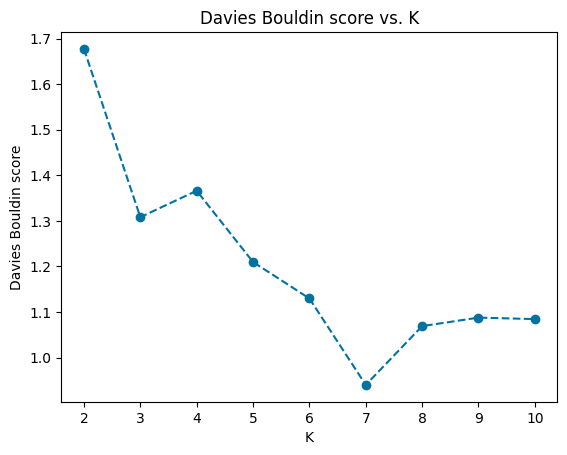

Final K parameter: 7


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 37.29860174604301
amount ratio 62.70139825395699
inv_amount ratio 99.95209028319965
amount ratio 0.047909716800340695
inv_amount ratio 80.1019412307474
amount ratio 19.898058769252607
inv_amount ratio 88.42314926538434
amount ratio 11.576850734615658
inv_amount ratio 94.2517212009369
amount ratio 5.748278799063098
inv_amount ratio 99.9995563915111
amount ratio 0.00044360848889204345
inv_amount ratio 99.97293988217758
amount ratio 0.027060117822414652
AUG THRESHOLD 40.20098115195952
RED THRESHOLD 46.562836931209425


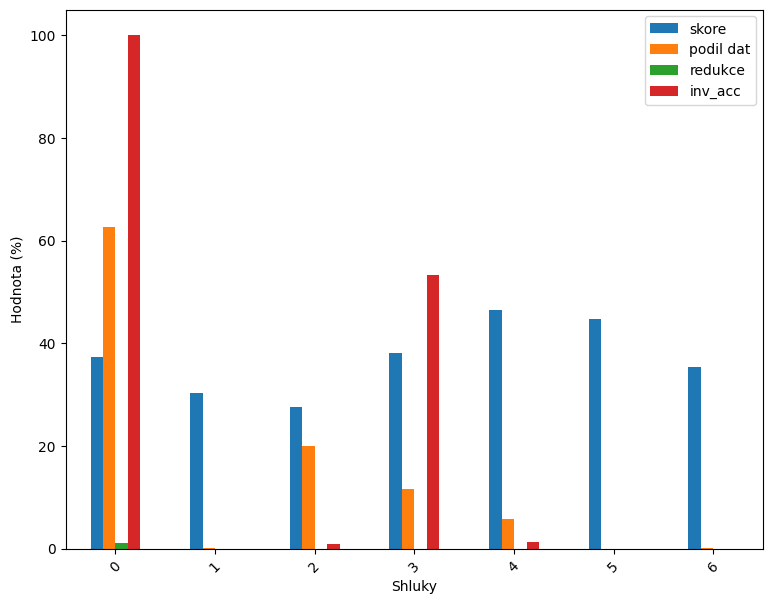

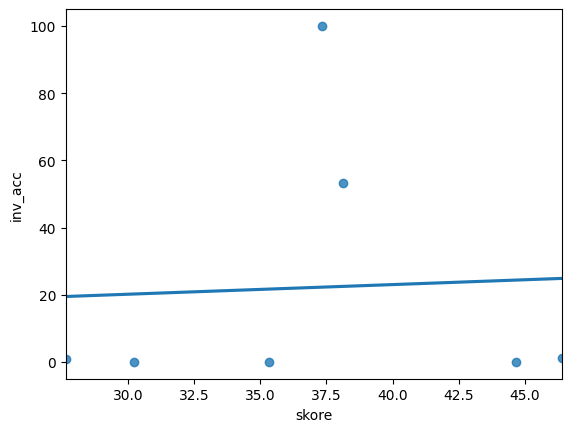

0    4
1    5
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
0 new data analysis
(148965, 24)
(148965, 21)


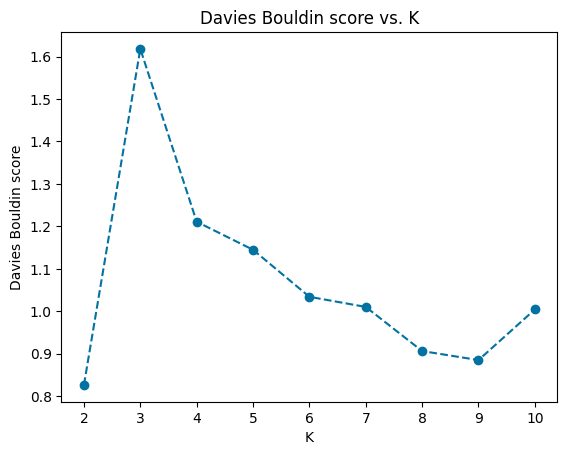

Final K parameter: 9


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 48.44963582049475
amount ratio 51.55036417950525
inv_amount ratio 88.03007417849831
amount ratio 11.969925821501695
inv_amount ratio 99.9993287013728
amount ratio 0.0006712986271943073
inv_amount ratio 99.99865740274561
amount ratio 0.0013425972543886146
inv_amount ratio 98.55805054878662
amount ratio 1.4419494512133721
inv_amount ratio 82.33007753499145
amount ratio 17.669922465008558
inv_amount ratio 99.9993287013728
amount ratio 0.0006712986271943073
inv_amount ratio 85.82821468130098
amount ratio 14.171785318699023
inv_amount ratio 96.80663243043668
amount ratio 3.1933675695633204
AUG THRESHOLD 47.95379946303245
RED THRESHOLD 38.0706131567072


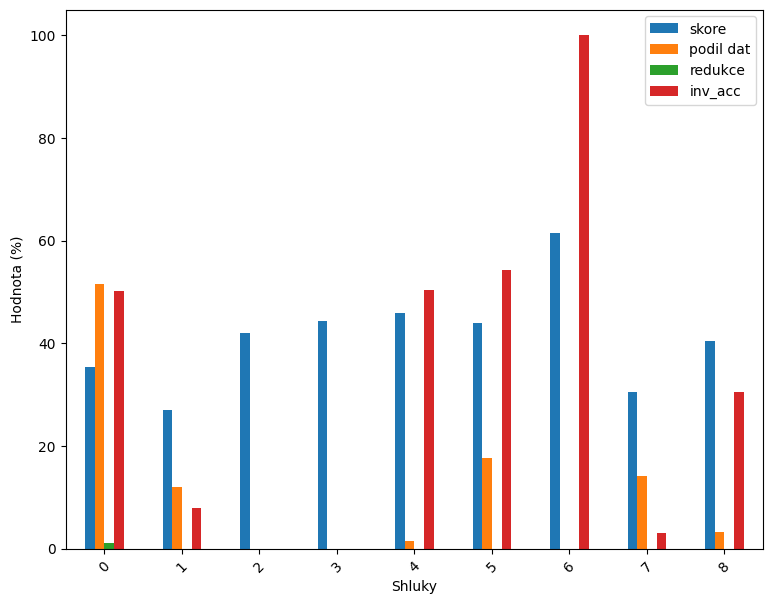

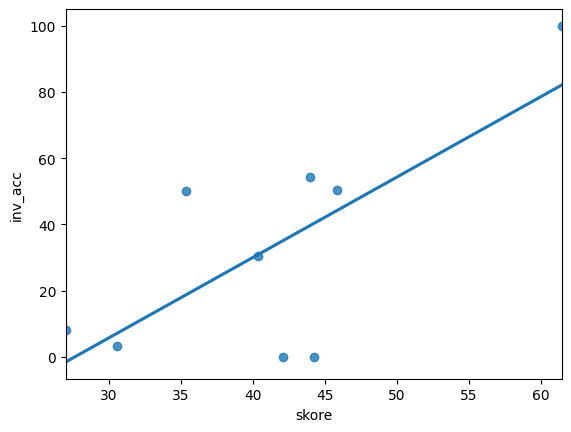

0    6
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
0 old data reduction
K ratio 14.285714285714286
Original ratio 62.70139825395699
New ratio 38.49368301511818
Reduction coef 0.613918626087519
0 new data augument
K ratio 11.11111111111111
Original ratio 0.0006712986271943073
new ratio aug: 8276.333333333334
new data sampled 0
(1, 26)
{0: 225424, 1: 38121, 'all': 263545} {0: 170854, 1: 0, 'all': 170854}
54570.0
       bytes_rev  bytes  packets  packets_rev  packets_sum  bytes_ration  \
52050         40  74396     1229            1         1230        1859.9   

       num_pkts_ration       time  av_pkt_size  av_pkt_size_rev  ...  \
52050           1229.0  80154.874    60.533767             40.0  ...   

           avgdelay  maxdelay  bursts  fazzel  time_leap_ration  autocorr  \
52050  13594.275862   40072.0       0       0               1.0  0.810976   

       stSum  ndSum  rdSum  is_doh  
52050     10      9      9       0  

[1 rows x 25 columns]
52050    6

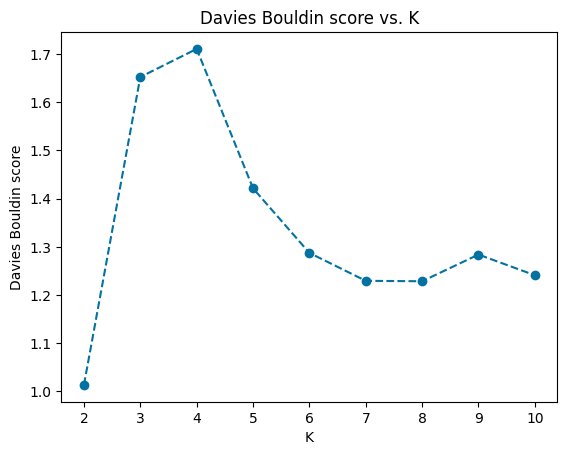

Final K parameter: 8


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 80.91865376039453
amount ratio 19.081346239605466
inv_amount ratio 73.11455628131476
amount ratio 26.885443718685238
inv_amount ratio 95.66643057632277
amount ratio 4.333569423677238
inv_amount ratio 80.71404212901027
amount ratio 19.28595787098974
inv_amount ratio 91.17546759004223
amount ratio 8.824532409957767
inv_amount ratio 83.8724062852496
amount ratio 16.1275937147504
inv_amount ratio 95.55887830854385
amount ratio 4.441121691456153
inv_amount ratio 98.979565069122
amount ratio 1.0204349308779936
AUG THRESHOLD 48.04134156897342
RED THRESHOLD 22.090295812456826


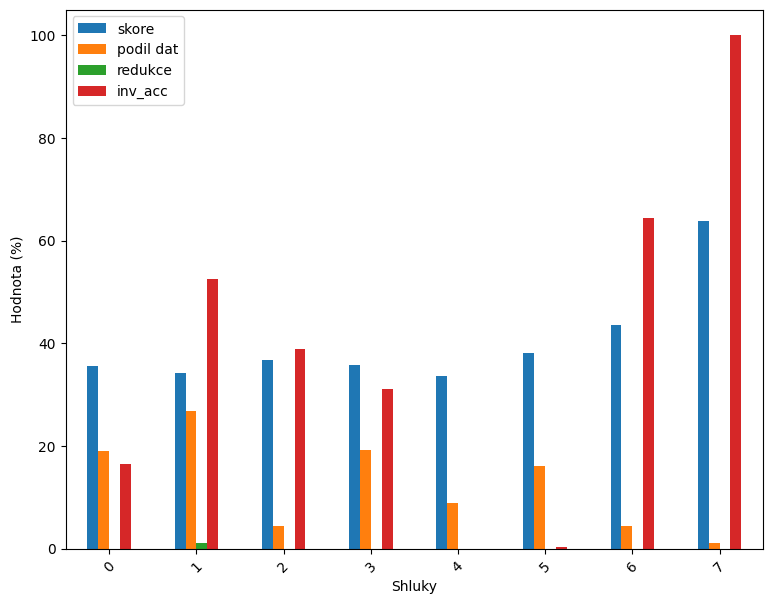

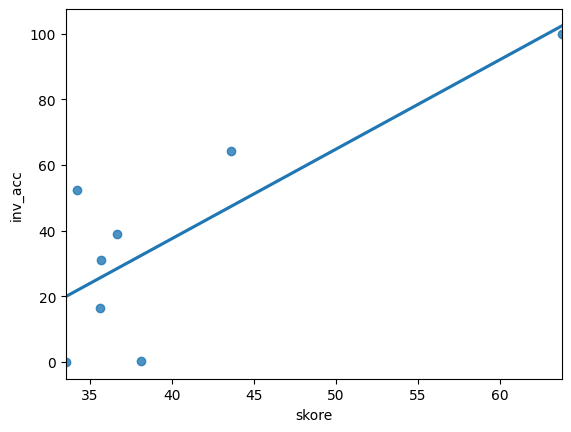

0    7
Name: augument, dtype: int64 --
 0    1
Name: reduction, dtype: int64
1 new data analysis
(193694, 24)
(193694, 21)


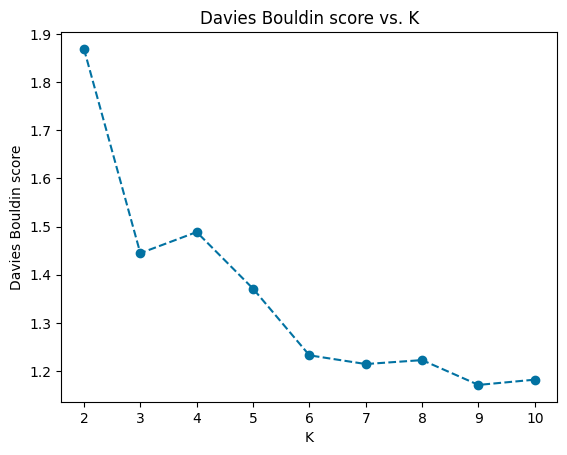

Final K parameter: 9


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 82.40472084834843
amount ratio 17.595279151651575
inv_amount ratio 87.52929879087633
amount ratio 12.47070120912367
inv_amount ratio 98.7531880182143
amount ratio 1.246811981785703
inv_amount ratio 75.01677904323314
amount ratio 24.983220956766857
inv_amount ratio 73.9857713713383
amount ratio 26.0142286286617
inv_amount ratio 88.06261422656355
amount ratio 11.937385773436452
inv_amount ratio 99.81310727229548
amount ratio 0.18689272770452364
inv_amount ratio 99.85750720208164
amount ratio 0.14249279791836608
inv_amount ratio 94.57701322704885
amount ratio 5.42298677295115
AUG THRESHOLD 49.63293688916644
RED THRESHOLD 21.04652278947817


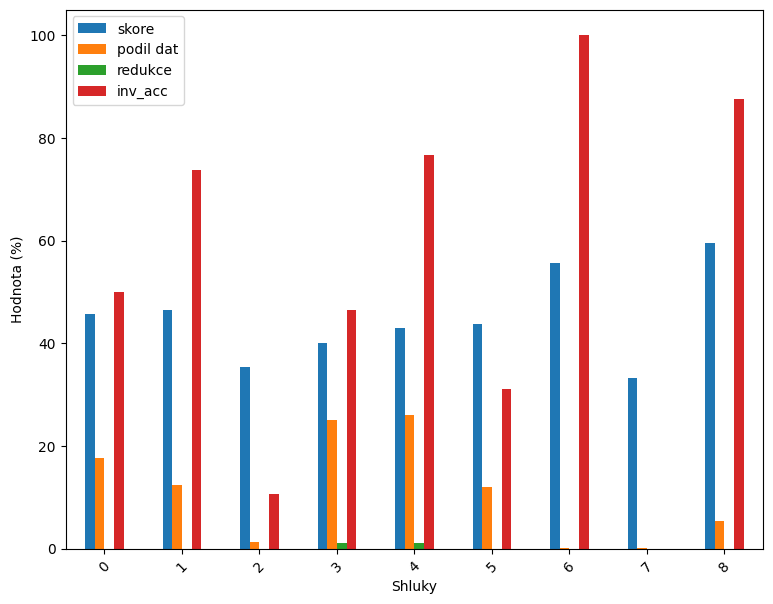

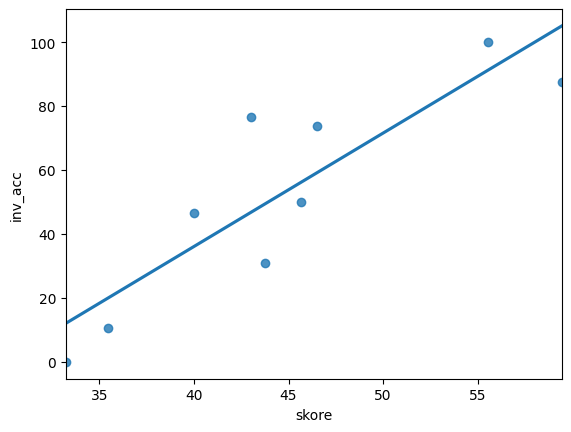

0    6
1    8
Name: augument, dtype: int64 --
 0    3
1    4
Name: reduction, dtype: int64
1 old data reduction
K ratio 12.5
Original ratio 26.885443718685238
New ratio 19.692557907714907
Reduction coef 0.7324678017367549
1 new data augument
K ratio 11.11111111111111
Original ratio 0.18689272770452364
new ratio aug: 30.225905463474522
K ratio 11.11111111111111
Original ratio 5.42298677295115
new ratio aug: 1.5244457138021494
new data sampled 1
(10866, 26)
{0: 225424, 1: 38121, 'all': 263545} {0: 170855, 1: 35379, 'all': 206234}
0.2523467697404749
        bytes_rev  bytes  packets  packets_rev  packets_sum  bytes_ration  \
88202          40   1582       11            1           12     39.550000   
13040          40   1401       10            1           11     35.025000   
5433           40   1401       10            1           11     35.025000   
170162         40   1582       11            1           12     39.550000   
24195          52   1634       12            1           13   

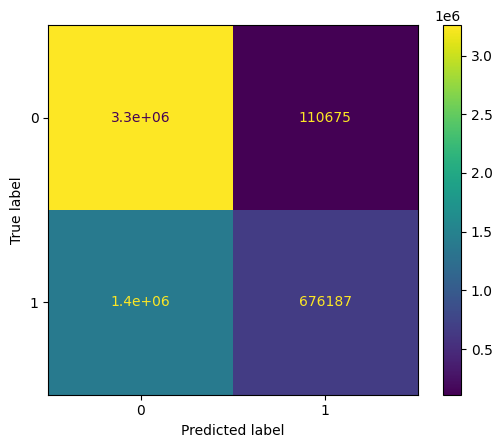

              precision    recall  f1-score   support

           0     0.7200    0.9415    0.8160   3369502
           1     0.8121    0.4087    0.5437   2086340

    accuracy                         0.7377   5455842
   macro avg     0.7661    0.6751    0.6798   5455842
weighted avg     0.7552    0.7377    0.7119   5455842



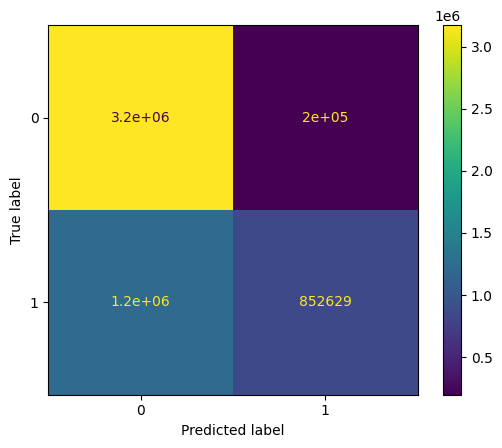

Improvement 9.747770426649367


In [124]:
# reduce all classes
def modification(metric='elbow',labels=[0,1],alg="kmeans",reduction_style='avg'):
    balance_old=old_data.class_balance(old_data.csv_data[old_data.label])
    print(balance_old)
    for label in labels:
        # class reduction
        if alg=="h2o":
            cluster_model_old=H2O_model(old_data,clf_dumb,label)
            cluster_model_new=H2O_model(new_data,clf_old,label)
        else:
            cluster_model_old=Sklearn_model(old_data,clf_dumb,label,model=alg,index=metric)
            cluster_model_new=Sklearn_model(new_data,clf_old,label,model=alg,index=metric)

        print(label,"old data analysis")
        cluster_model_old.cluster_analysis(pca=True)

        print(label,"new data analysis")
        cluster_model_new.cluster_analysis(pca=True)

        if reduction_style=='uni':
            print(label,"old data reduction")
            old_data.reduce(cluster_model_old,1/cluster_model_old.size)
            print(label,"new data augument")
            new_data.augument(cluster_model_new,1/cluster_model_new.size)
        else:
            print(label,"old data reduction")
            old_data.reduce(cluster_model_old)
            print(label,"new data augument")
            new_data.augument(cluster_model_new)
        
        balance_new=old_data.class_balance(old_data.newdata[old_data.label].reset_index(drop=True))
        print(balance_old,balance_new)
        space_to_aug=balance_old[label]-balance_new[label]
        balance_aug=new_data.class_balance(new_data.newdata[new_data.label].reset_index(drop=True))
        ratio=space_to_aug/balance_aug[label]
        
        aug_data=new_data.newdata[new_data.newdata[new_data.label]==label].drop(columns=['predict'])
        labels=new_data.newdata[new_data.newdata[new_data.label]==label].pop('predict')
        
        print(ratio)
        print(aug_data)
        print(labels)
        if ratio > 1:
            old_data.newdata=pd.concat([old_data.newdata,aug_data])
        else:
            aug_data, _, _, _ =train_test_split(aug_data, labels, test_size=1-ratio, random_state=42, shuffle=True, stratify=labels)
            old_data.newdata=pd.concat([old_data.newdata,aug_data])
        
framework_result=pd.DataFrame()
for alg in ['kmeans']:#h2o,aglomerative
    print(alg)
    if alg== 'h2o':
        k_methods=['default']
    else:
        k_methods=['bouldin']#,'silhouette','elbow','bouldin','PRE']:
    for metric in k_methods:
        print(metric)
        for reduction_style in ['avg']:#uni
            print(reduction_style)
            
            modification(metric=metric,alg=alg, reduction_style=reduction_style)
            
            clf_reduced=AdaBoostClassifier(
                base_estimator=DecisionTreeClassifier(max_depth=6,criterion='entropy',max_features=None),n_estimators=5,algorithm='SAMME.R'
                )
            clustered_result=old_data.compare_models(clf_old,clf_reduced,test_data)
            tmp=old_data.prepare_model_result(clustered_result,'clustering_'+reduction_style,use_case,alg+'_'+metric)
            framework_result=pd.concat([framework_result,tmp])

            balance=old_data.class_balance(old_data.newdata[old_data.label].reset_index(drop=True))
            sampling_ratio=balance[1]/balance[0]
            balance_dict={0:balance[0],1:balance[1]}
            #old_data.set_data(pd.concat([X_train_old,y_train_old],axis=1))
            #old_data.set_newdata()


In [59]:
old_data.newdata

,bytes_rev,bytes,packets,packets_rev,packets_sum,bytes_ration,num_pkts_ration,time,av_pkt_size,av_pkt_size_rev,...,avgdelay,maxdelay,bursts,fazzel,time_leap_ration,autocorr,stSum,ndSum,rdSum,is_doh
0,244230,9040,55,67,122,0.037014,0.820896,6864.346,164.363636,3645.223881,...,1074.027034,1791.234,0,0,1.0,0.257061,-4,-7,-7,0
2,91447,2268,23,78,101,0.024801,0.294872,18514.792,98.608696,1172.397436,...,200.477103,267.992,0,0,1.0,0.334853,-4,-9,-9,0
5,5403,3763,21,22,43,0.696465,0.954545,7733.572,179.190476,245.590909,...,3275.412900,7707.544,0,0,1.0,0.000000,1,-2,0,0
6,3136,2259,19,25,44,0.720344,0.760000,9655.072,118.894737,125.440000,...,4273.259857,5436.900,0,0,1.0,0.042446,-1,0,0,0
9,112,216,4,2,6,1.928571,2.000000,51.110,54.000000,56.000000,...,0.000000,0.000,0,0,0.0,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387298,92,172,4,2,6,1.869565,2.000000,19942.522,43.000000,46.000000,...,0.000000,0.000,0,0,0.0,0.000000,0,0,0,1
387318,288,216,3,4,7,0.750000,0.750000,3269.108,72.000000,72.000000,...,0.000000,0.000,0,0,0.0,0.000000,0,0,0,1
387330,112,216,4,2,6,1.928571,2.000000,37.514,54.000000,56.000000,...,0.000000,0.000,0,0,0.0,0.000000,0,0,0,1
387336,164,216,4,3,7,1.317073,1.333333,10158.542,54.000000,54.666667,...,0.000000,0.000,0,0,0.0,0.000000,0,0,0,1


# DoH data

DOH
({1: 1936940}, {0: 1489653}, 3426593)

aglomerative
bouldin
avg
(7448, 21)


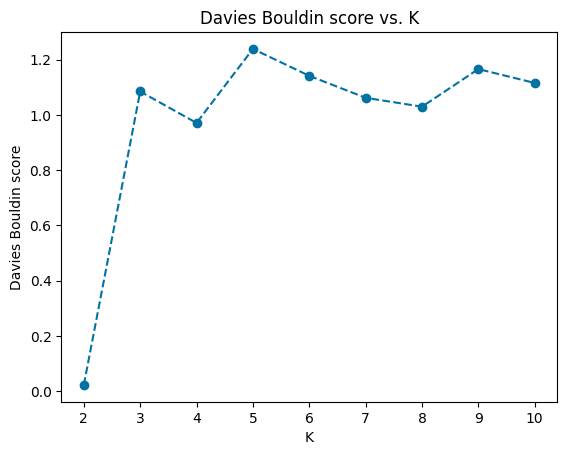

Final K parameter: 2


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 0.013426423200854742
amount ratio 99.98657357679915
inv_amount ratio 99.98657357679915
amount ratio 0.01342642320085929
AUG THRESHOLD 37.25403632808525
RED THRESHOLD 83.32438238453277


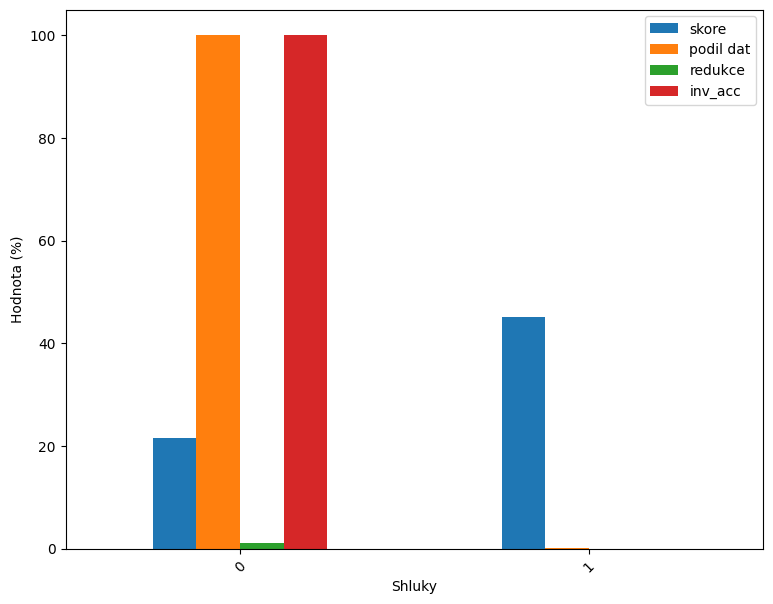

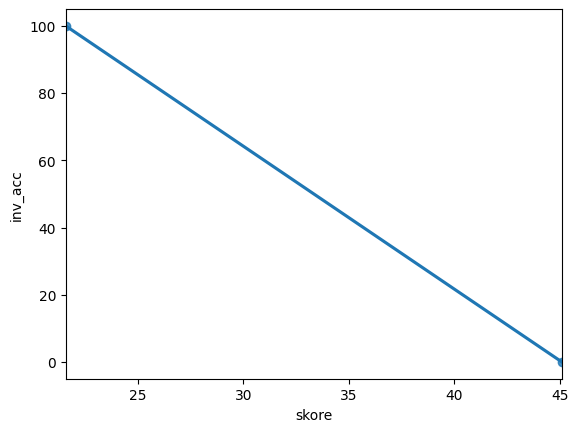

0    1
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
K ratio 50.0
Original ratio 99.98657357679915
New ratio 75.0
Reduction coef 0.7500335705653283
(9684, 21)


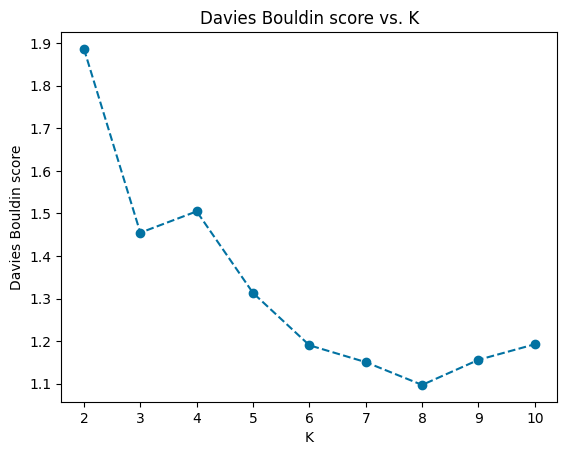

Final K parameter: 8


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 63.10408921933085
amount ratio 36.89591078066915
inv_amount ratio 72.79016935150764
amount ratio 27.209830648492357
inv_amount ratio 99.60760016522099
amount ratio 0.39239983477901696
inv_amount ratio 89.04378356051218
amount ratio 10.956216439487815
inv_amount ratio 99.76249483684428
amount ratio 0.23750516315572076
inv_amount ratio 82.25939694341182
amount ratio 17.740603056588185
inv_amount ratio 98.55431639818256
amount ratio 1.4456836018174308
inv_amount ratio 94.87814952498968
amount ratio 5.121850475010326
AUG THRESHOLD 48.9022488719037
RED THRESHOLD 28.7639405204461


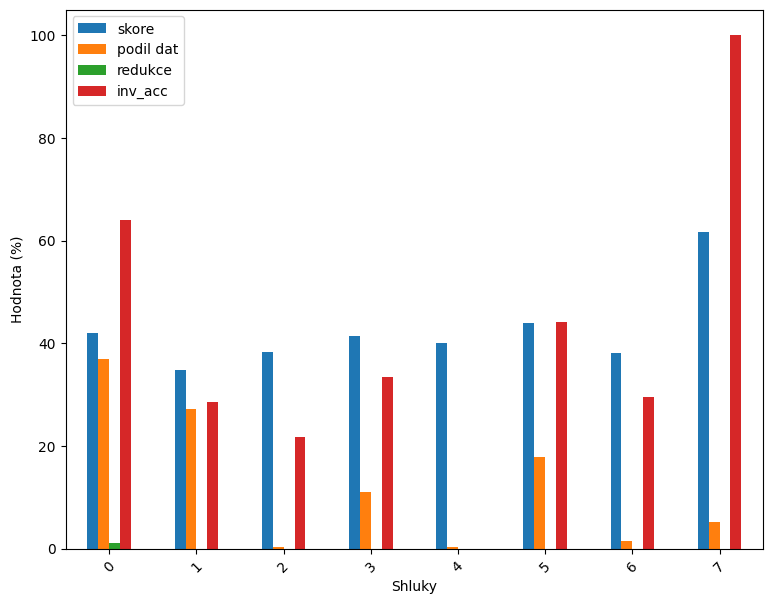

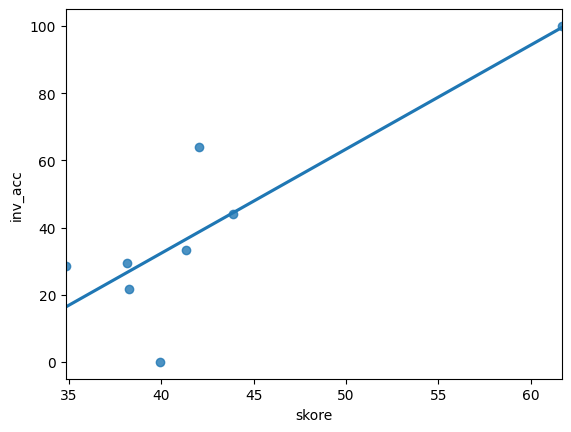

0    7
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
K ratio 12.5
Original ratio 36.89591078066915
New ratio 24.70053696819496
Reduction coef 0.6693954659949622
Old class balance ({1: 9684}, {0: 7448}, 17132)
New class balance ({1: 8503}, {0: 5587}, 14090)
Reduction ratio 17.75624562222741
              precision    recall  f1-score   support

           0     0.9278    0.9237    0.9258   1482205
           1     0.9415    0.9447    0.9431   1927256

    accuracy                         0.9356   3409461
   macro avg     0.9347    0.9342    0.9345   3409461
weighted avg     0.9356    0.9356    0.9356   3409461



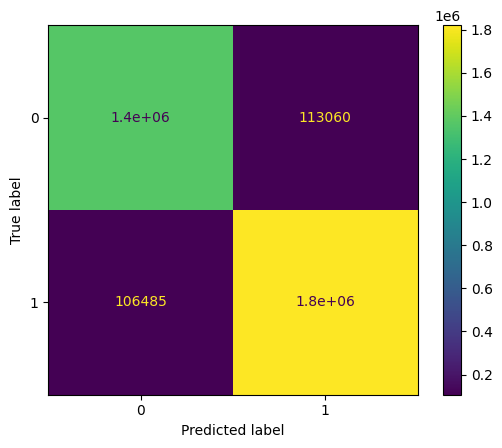

              precision    recall  f1-score   support

           0     0.9294    0.9162    0.9227   1482205
           1     0.9362    0.9465    0.9413   1927256

    accuracy                         0.9333   3409461
   macro avg     0.9328    0.9313    0.9320   3409461
weighted avg     0.9333    0.9333    0.9332   3409461



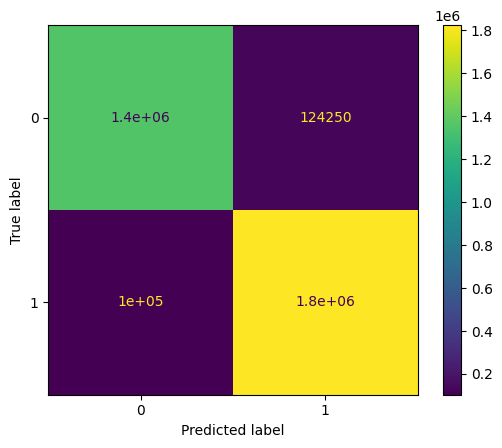

Improvement -3.6343492456281123
uni
(7448, 21)


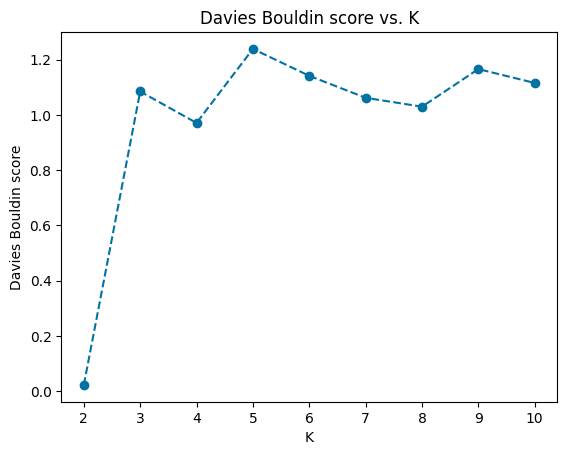

Final K parameter: 2


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 0.013426423200854742
amount ratio 99.98657357679915
inv_amount ratio 99.98657357679915
amount ratio 0.01342642320085929
AUG THRESHOLD 37.25403632808525
RED THRESHOLD 83.32438238453277


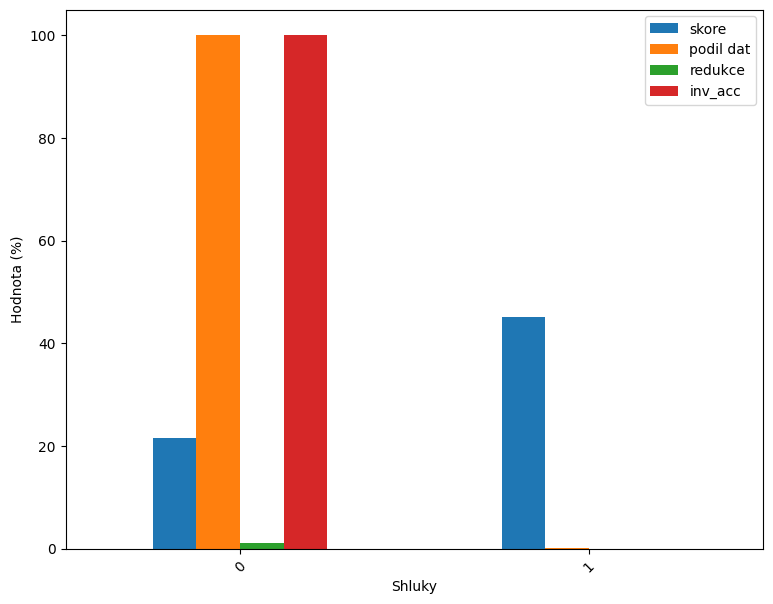

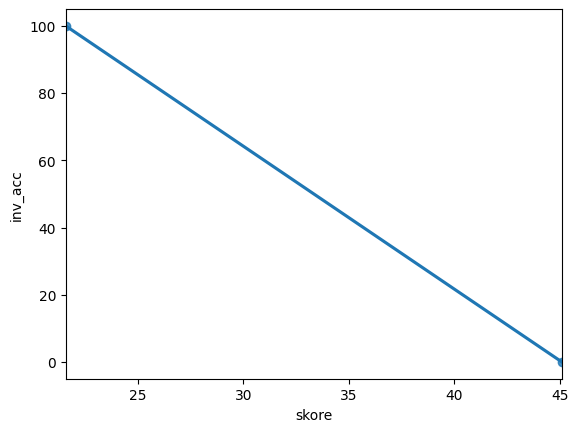

0    1
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
K ratio 50.0
Original ratio 99.98657357679915
New ratio 50.0
Reduction coef 0.5000671411306566
(9684, 21)


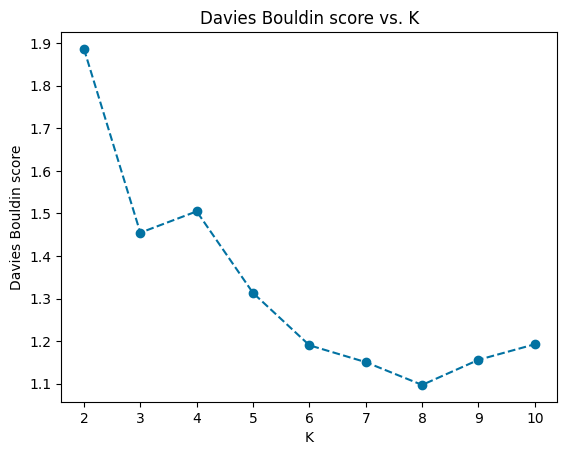

Final K parameter: 8


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 63.10408921933085
amount ratio 36.89591078066915
inv_amount ratio 72.79016935150764
amount ratio 27.209830648492357
inv_amount ratio 99.60760016522099
amount ratio 0.39239983477901696
inv_amount ratio 89.04378356051218
amount ratio 10.956216439487815
inv_amount ratio 99.76249483684428
amount ratio 0.23750516315572076
inv_amount ratio 82.25939694341182
amount ratio 17.740603056588185
inv_amount ratio 98.55431639818256
amount ratio 1.4456836018174308
inv_amount ratio 94.87814952498968
amount ratio 5.121850475010326
AUG THRESHOLD 48.9022488719037
RED THRESHOLD 28.7639405204461


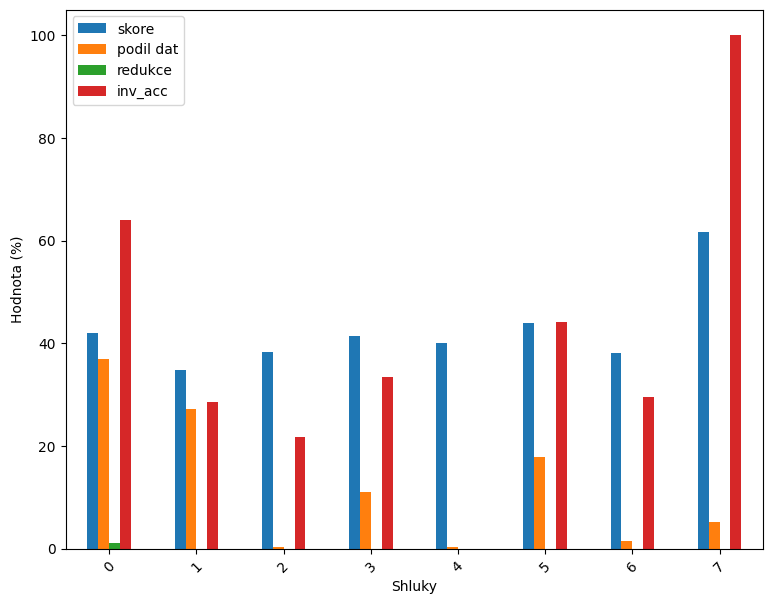

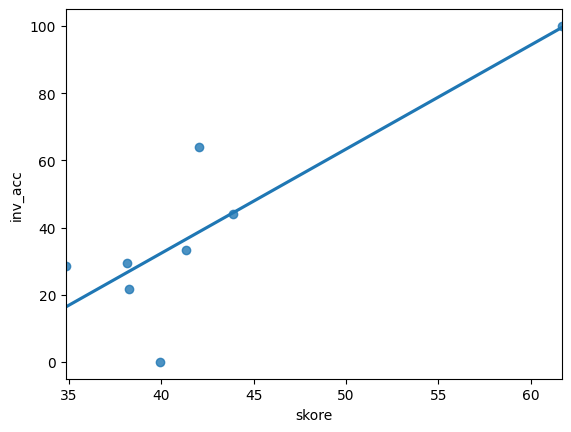

0    7
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
K ratio 12.5
Original ratio 36.89591078066915
New ratio 12.494836844279224
Reduction coef 0.33879093198992444
Old class balance ({1: 9684}, {0: 7448}, 17132)
New class balance ({1: 7321}, {0: 3725}, 11046)
Reduction ratio 35.52416530469297
              precision    recall  f1-score   support

           0     0.9278    0.9237    0.9258   1482205
           1     0.9415    0.9447    0.9431   1927256

    accuracy                         0.9356   3409461
   macro avg     0.9347    0.9342    0.9345   3409461
weighted avg     0.9356    0.9356    0.9356   3409461



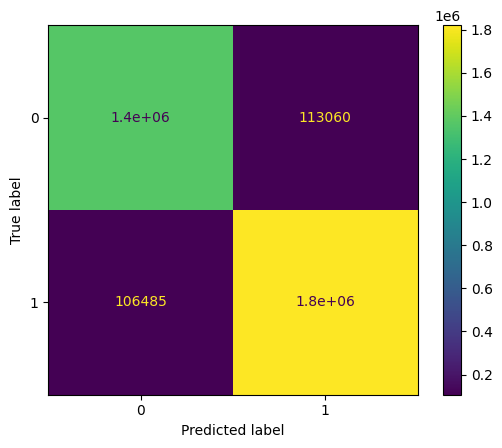

              precision    recall  f1-score   support

           0     0.9181    0.9089    0.9135   1482205
           1     0.9305    0.9376    0.9340   1927256

    accuracy                         0.9251   3409461
   macro avg     0.9243    0.9233    0.9237   3409461
weighted avg     0.9251    0.9251    0.9251   3409461



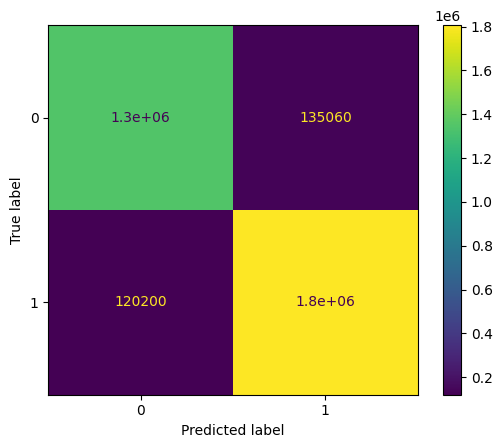

Improvement -16.307117908258473
elbow
avg
(7448, 21)


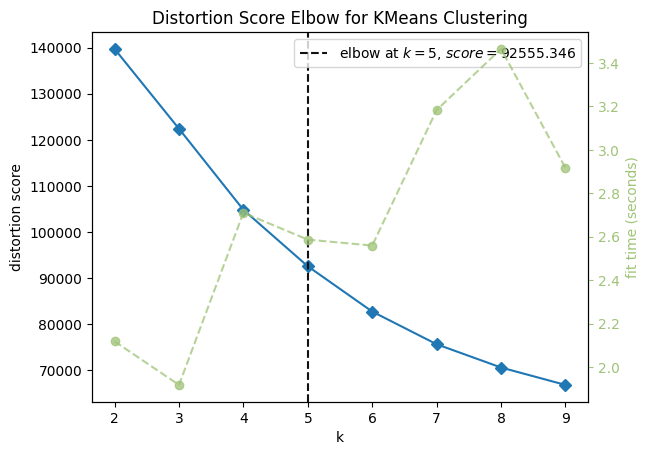

Final K parameter: 5


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 29.1890440386681
amount ratio 70.8109559613319
inv_amount ratio 89.39312567132116
amount ratio 10.60687432867884
inv_amount ratio 83.8077336197637
amount ratio 16.192266380236305
inv_amount ratio 99.98657357679915
amount ratio 0.01342642320085929
inv_amount ratio 97.6235230934479
amount ratio 2.3764769065520945
AUG THRESHOLD 39.92723832682719
RED THRESHOLD 53.87397064088793


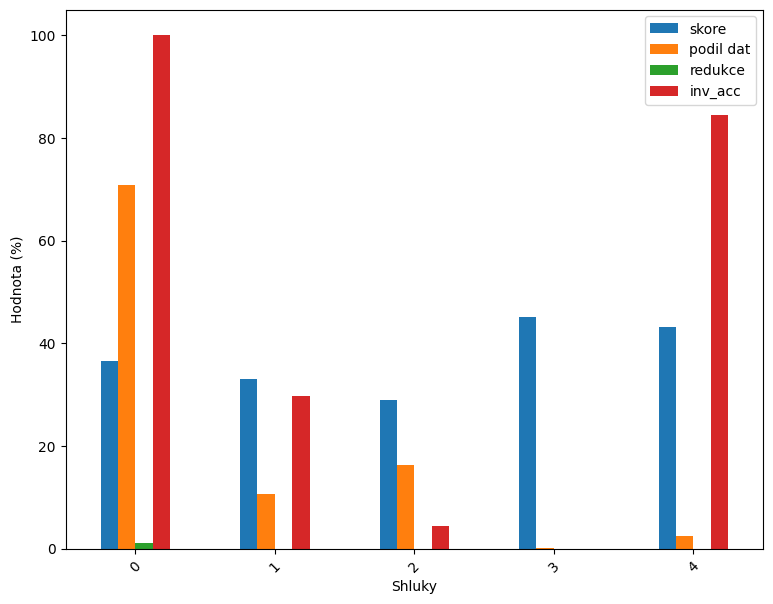

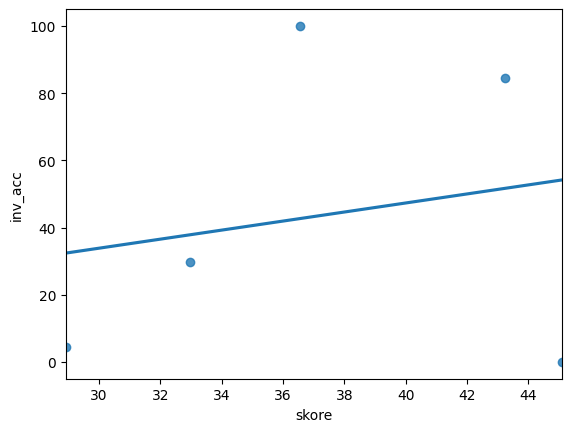

0    3
1    4
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
K ratio 20.0
Original ratio 70.8109559613319
New ratio 45.40816326530612
Reduction coef 0.6412210845657945
(9684, 21)


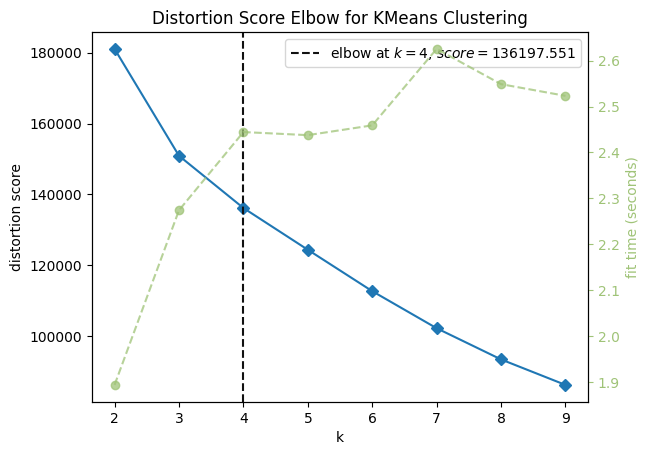

Final K parameter: 4


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 65.98513011152417
amount ratio 34.014869888475836
inv_amount ratio 45.363486162742674
amount ratio 54.636513837257326
inv_amount ratio 99.60760016522099
amount ratio 0.39239983477901696
inv_amount ratio 89.04378356051218
amount ratio 10.956216439487815
AUG THRESHOLD 40.49457895702892
RED THRESHOLD 44.75767589150488


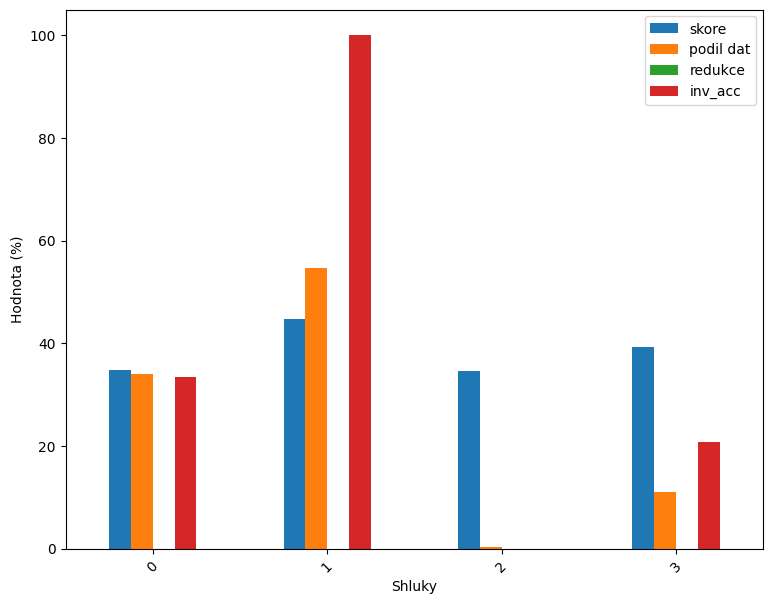

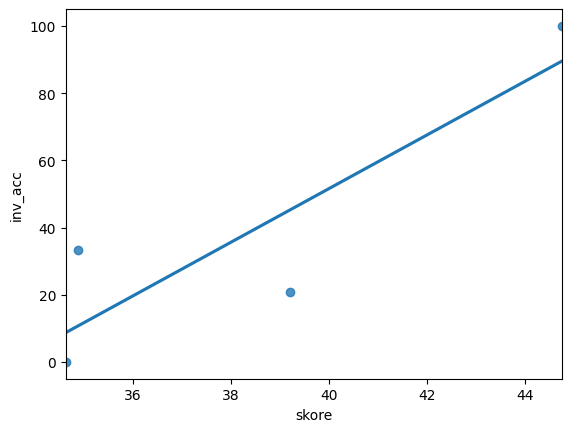

0    1
Name: augument, dtype: int64 --
 Series([], Name: reduction, dtype: int64)
Old class balance ({1: 9684}, {0: 7448}, 17132)
New class balance ({1: 9684}, {0: 5556}, 15240)
Reduction ratio 11.043660985290686
              precision    recall  f1-score   support

           0     0.9278    0.9237    0.9258   1482205
           1     0.9415    0.9447    0.9431   1927256

    accuracy                         0.9356   3409461
   macro avg     0.9347    0.9342    0.9345   3409461
weighted avg     0.9356    0.9356    0.9356   3409461



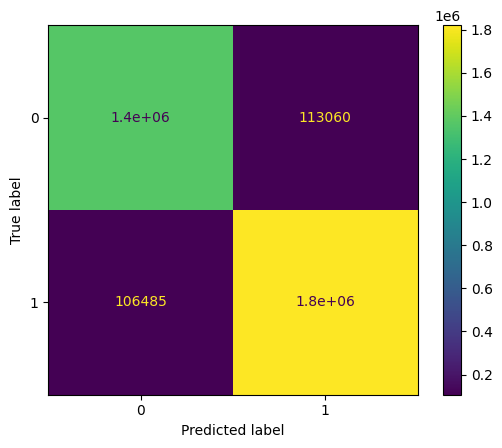

              precision    recall  f1-score   support

           0     0.9378    0.9027    0.9199   1482205
           1     0.9272    0.9540    0.9404   1927256

    accuracy                         0.9317   3409461
   macro avg     0.9325    0.9283    0.9302   3409461
weighted avg     0.9318    0.9317    0.9315   3409461



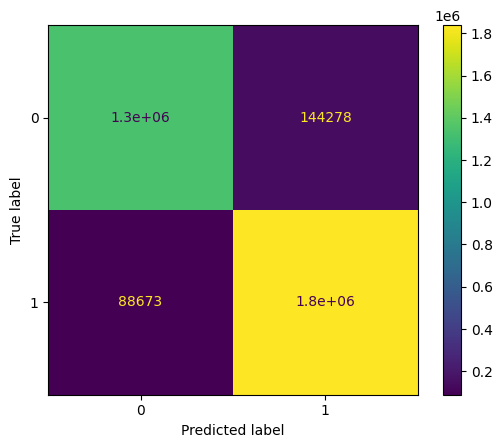

Improvement -6.338326888124703
uni
(7448, 21)


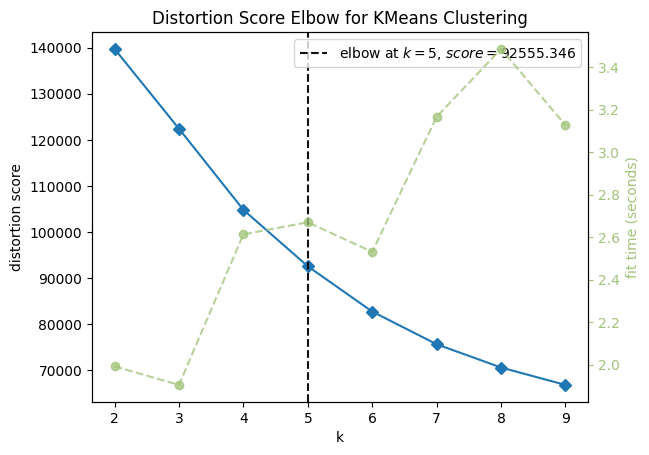

Final K parameter: 5


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 29.1890440386681
amount ratio 70.8109559613319
inv_amount ratio 89.39312567132116
amount ratio 10.60687432867884
inv_amount ratio 83.8077336197637
amount ratio 16.192266380236305
inv_amount ratio 99.98657357679915
amount ratio 0.01342642320085929
inv_amount ratio 97.6235230934479
amount ratio 2.3764769065520945
AUG THRESHOLD 39.92723832682719
RED THRESHOLD 53.87397064088793


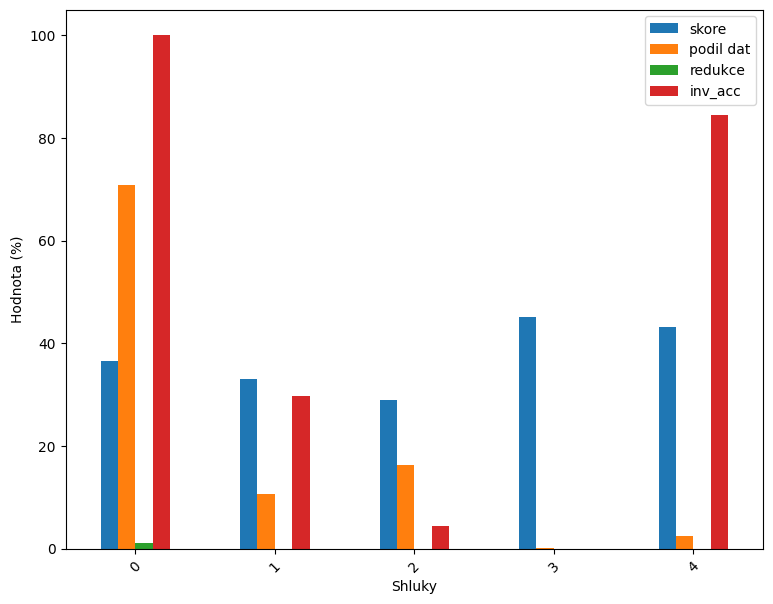

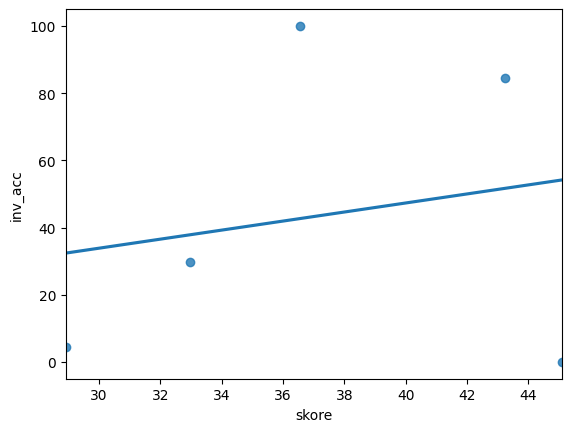

0    3
1    4
Name: augument, dtype: int64 --
 0    0
Name: reduction, dtype: int64
K ratio 20.0
Original ratio 70.8109559613319
New ratio 20.00537056928034
Reduction coef 0.2824421691315889
(9684, 21)


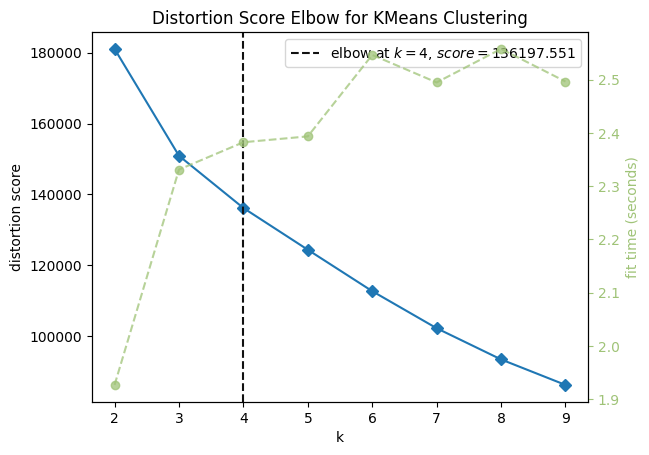

Final K parameter: 4


/home/netmon/.local/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


inv_amount ratio 65.98513011152417
amount ratio 34.014869888475836
inv_amount ratio 45.363486162742674
amount ratio 54.636513837257326
inv_amount ratio 99.60760016522099
amount ratio 0.39239983477901696
inv_amount ratio 89.04378356051218
amount ratio 10.956216439487815
AUG THRESHOLD 40.49457895702892
RED THRESHOLD 44.75767589150488


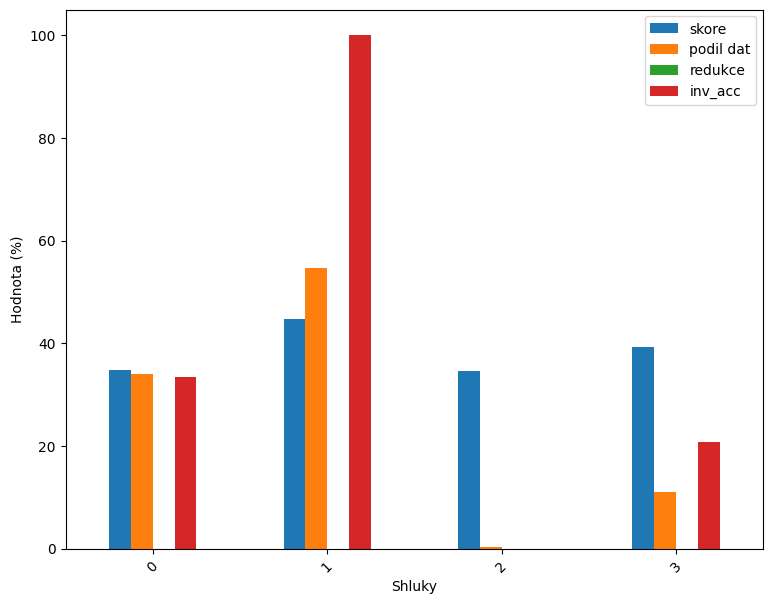

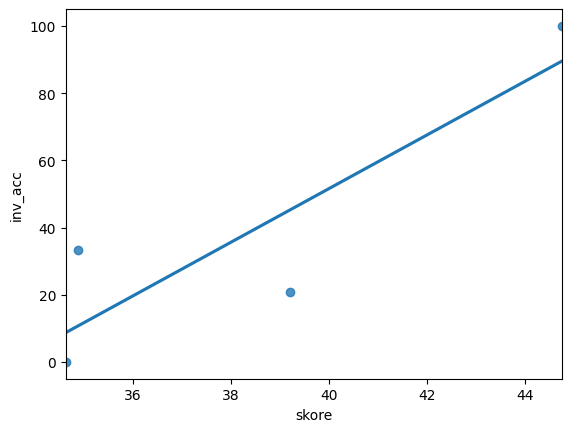

0    1
Name: augument, dtype: int64 --
 Series([], Name: reduction, dtype: int64)
Old class balance ({1: 9684}, {0: 7448}, 17132)
New class balance ({1: 9684}, {0: 3664}, 13348)
Reduction ratio 22.08732197058137
              precision    recall  f1-score   support

           0     0.9278    0.9237    0.9258   1482205
           1     0.9415    0.9447    0.9431   1927256

    accuracy                         0.9356   3409461
   macro avg     0.9347    0.9342    0.9345   3409461
weighted avg     0.9356    0.9356    0.9356   3409461



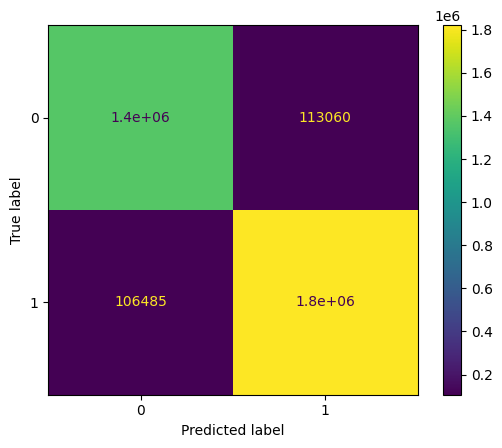

              precision    recall  f1-score   support

           0     0.9542    0.8561    0.9025   1482205
           1     0.8974    0.9684    0.9316   1927256

    accuracy                         0.9196   3409461
   macro avg     0.9258    0.9122    0.9170   3409461
weighted avg     0.9221    0.9196    0.9189   3409461



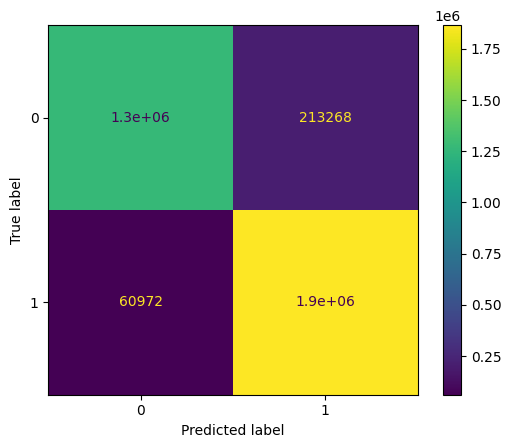

Improvement -25.888690625668893


In [111]:
use_case="DOH"
label="is_doh"
class_values=(True,False)
framework_result=pd.DataFrame()
filename="doh_test_analyze_3M.csv"#"doh_train_old+new.csv"

train_data=Modifier(f"{filename}",label,use_case,class_values)
train_data.load()
print(use_case)
print(train_data.class_balance(train_data.csv_data[label]))
#print(train_data.csv_data)
print()
clf=DecisionTreeClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(train_data.get_all_features(), train_data.get_all_label(), test_size=0.995, random_state=42, shuffle=True, stratify=train_data.get_all_label())
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
original_result=classification_report(y_test,pred,digits=4,output_dict=True)
train_data.cnt_new=train_data.class_balance(y_train)
tmp=train_data.prepare_model_result(original_result,'original',use_case)
framework_result=pd.concat([framework_result,tmp])
# metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, pred)).plot()
# plt.show()
train_data.set_data(pd.concat([X_train,y_train],axis=1))
test_data=Dataset(_,label,use_case,class_values)
test_data.set_data(pd.concat([X_test,y_test],axis=1))

# just small sample to train classifier
dumb_X_train, _, dumb_y_train, _ = train_test_split(train_data.get_all_features(), train_data.get_all_label(), test_size=0.8, random_state=42, shuffle=True, stratify=train_data.get_all_label())
clf_dumb=DecisionTreeClassifier(random_state=42)
clf_dumb.fit(dumb_X_train, dumb_y_train)

# reduce all classes
def reduction(metric='elbow',labels=[0,1],alg="kmeans",reduction_style='avg'):
    for label in labels:
        # class reduction
        if alg=="h2o":
            cluster_model=H2O_model(train_data,clf_dumb,label)
        else:
            cluster_model=Sklearn_model(train_data,clf_dumb,label,model=alg,index=metric)

        cluster_model.cluster_analysis(pca=True)
        if reduction_style=='uni':
            train_data.reduce(cluster_model,1/cluster_model.size)
        else:
            train_data.reduce(cluster_model)

for alg in ['aglomerative']:#h2o
    print(alg)
    if alg== 'h2o':
        k_methods=['default']
    else:
        k_methods=['bouldin','elbow']#,'silhouette','elbow','bouldin','PRE']:
    for metric in k_methods:
        print(metric)
        for reduction_style in ['avg','uni']:
            print(reduction_style)
            
            reduction(metric=metric,alg=alg, reduction_style=reduction_style)

            clf_new=DecisionTreeClassifier(random_state=42)
            clustered_result=train_data.compare_models(clf,clf_new,test_data)
            tmp=train_data.prepare_model_result(clustered_result,'clustering_'+reduction_style,use_case,alg+'_'+metric)
            framework_result=pd.concat([framework_result,tmp])

            balance=train_data.class_balance(train_data.newdata[train_data.label].reset_index(drop=True))
            sampling_ratio=balance[0][1]/balance[1][0]
            balance_dict={0:balance[1][0],1:balance[0][1]}
            train_data.set_data(pd.concat([X_train,y_train],axis=1))
            train_data.set_newdata()



In [69]:
balance_dict#={1:5901,0:5129}

{1: 5901, 0: 5129}

In [112]:
framework_result

,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support
0,DOH,original,default,0.935607,0.935581,0.935607,0.935590,0.000000,"9684,7448"
0,DOH,clusteringavg,aglomerativebouldin,0.933307,0.933265,0.933307,0.933250,-3.634349,"8503,5587"
0,DOH,clusteringuni,aglomerativebouldin,0.925132,0.925078,0.925132,0.925087,-16.307118,"7321,3725"
0,DOH,clusteringavg,aglomerativeelbow,0.931675,0.931848,0.931675,0.931508,-6.338327,"9684,5556"
0,DOH,clusteringuni,aglomerativeelbow,0.919565,0.922098,0.919565,0.918916,-25.888691,"9684,3664"


In [83]:
framework_result

,Dataset,Method,Metric,Acc,Precision,Recall,F1,Impr,Support
0,DOH,original,default,0.935607,0.935581,0.935607,0.935590,0.000000,"9684,7448"
0,DOH,clustering_uniform,aglo,0.931675,0.931848,0.931675,0.931508,-6.338327,"9684,5556"


### IMBL 

In [113]:
imbl=[#(NearMiss(sampling_strategy=balance_dict,version=1),"near_miss1"),#
      #(NearMiss(sampling_strategy=balance_dict,version=2),"near_miss2"),
      #(NearMiss(sampling_strategy=balance_dict,version=3),"near_miss3"),
      #(CondensedNearestNeighbour(random_state=42,sampling_strategy='all',n_jobs=-1),"condensed_NN"),
      #(EditedNearestNeighbours(),"edited_NN"),
      #(RepeatedEditedNearestNeighbours(sampling_strategy='all',n_jobs=-1),"rep_edited__NN"),
      #(InstanceHardnessThreshold(sampling_strategy=balance_dict,random_state=42, estimator=LogisticRegression(solver='lbfgs', max_iter=200)),"inst_hard_tresh"),
      #(NeighbourhoodCleaningRule(sampling_strategy='all',n_jobs=-1),"neigh_clean_rule"),
      #(OneSidedSelection(sampling_strategy='all',n_jobs=-1,random_state=42),"one_sided_sel"),
      #(RandomUnderSampler(sampling_strategy=balance_dict,random_state=42),"random_sampler"),
      #(TomekLinks(sampling_strategy='all',n_jobs=-1),"tomek_links"),
      #(AllKNN(sampling_strategy='all',n_jobs=-1),"allKNN"),
      #(ClusterCentroids(sampling_strategy=balance_dict,random_state=42),"cluster_centroids"),
      #(ClusterCentroids(sampling_strategy=balance_dict,random_state=42,estimator=KMeans(n_clusters=cluster_model.size)),"cluster_centroids_est_k")
      ]
overall_result=framework_result
for sampler in imbl:
  print(sampler[1])
  train_data.apply_imbalanced_lib(sampler[0])
  imbl_result=train_data.compare_models(clf,clf_new,test_data)
  tmp=train_data.prepare_model_result(imbl_result,sampler[1],use_case)
  overall_result=pd.concat([overall_result,tmp])

overall_result.reset_index(inplace=True,drop=True)
print(overall_result)

  Dataset         Method               Metric       Acc  Precision    Recall  \
0     DOH       original              default  0.935607   0.935581  0.935607   
1     DOH  clusteringavg  aglomerativebouldin  0.933307   0.933265  0.933307   
2     DOH  clusteringuni  aglomerativebouldin  0.925132   0.925078  0.925132   
3     DOH  clusteringavg    aglomerativeelbow  0.931675   0.931848  0.931675   
4     DOH  clusteringuni    aglomerativeelbow  0.919565   0.922098  0.919565   

         F1       Impr    Support  
0  0.935590   0.000000  9684,7448  
1  0.933250  -3.634349  8503,5587  
2  0.925087 -16.307118  7321,3725  
3  0.931508  -6.338327  9684,5556  
4  0.918916 -25.888691  9684,3664  


In [114]:
overall_result.to_csv(f"{use_case}_comparation.csv",mode='a',index=False)

# Adasyn data

diabetes.csv
({1: 268}, {0: 500}, 768)

(250, 8)
CRIT 0.0990625
SSE 1660.7357698028668


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SSE 1333.2058252322868
PRE 0.1972197808501822 2


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SSE 1108.8436295563995
PRE 0.16828774029456123 3


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SSE 969.5073811833315
PRE 0.1256590601767811 4
SSE 871.0884364408246
PRE 0.10151438416320438

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 5


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


SSE 772.8856084126862
PRE 0.11273577276422672 6
SSE 702.9753820969485
PRE 0.09045352320547911 7
Final K parameter: 6
SSE 772.8856084126862


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


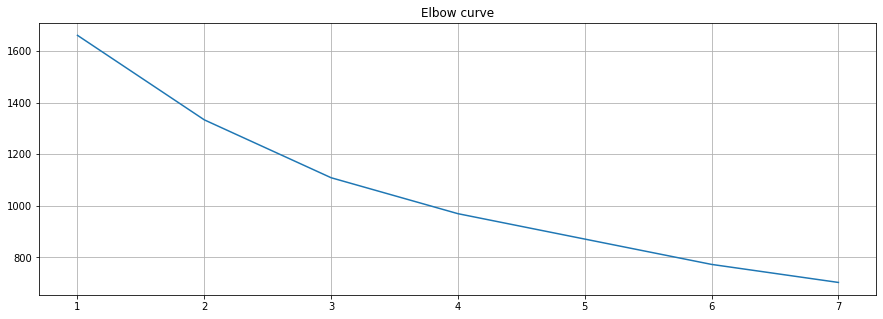

inv_amount ratio 70.4
amount ratio 29.599999999999998
inv_amount ratio 72.0
amount ratio 28.000000000000004
inv_amount ratio 86.8
amount ratio 13.200000000000001
inv_amount ratio 88.8
amount ratio 11.200000000000001
inv_amount ratio 85.6
amount ratio 14.399999999999999
inv_amount ratio 96.4
amount ratio 3.5999999999999996
AUG THRESHOLD 44.9687580588542
RED THRESHOLD 25.288888888888888


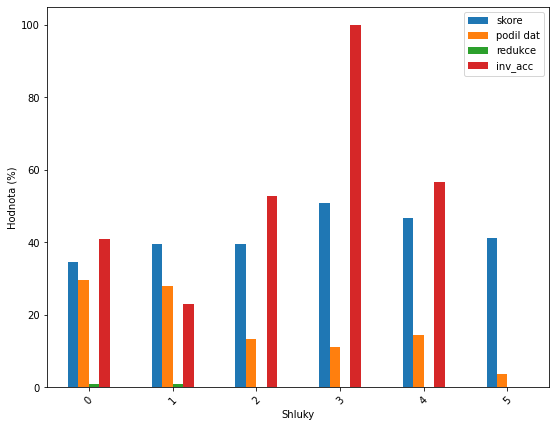

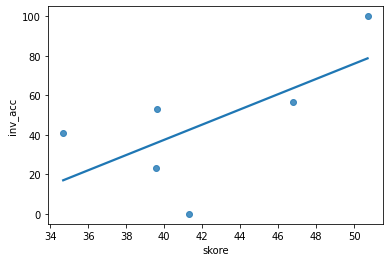

0    3
1    4
Name: augument, dtype: int64 --
 0    0
1    1
Name: reduction, dtype: int64
K ratio 16.666666666666668
Original ratio 29.599999999999998
New ratio 16.8
Reduction coef 0.5630630630630631
K ratio 16.666666666666668
Original ratio 28.000000000000004
New ratio 16.8
Reduction coef 0.5952380952380951
Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



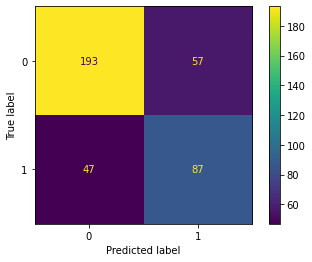

              precision    recall  f1-score   support

           0     0.7960    0.7960    0.7960       250
           1     0.6194    0.6194    0.6194       134

    accuracy                         0.7344       384
   macro avg     0.7077    0.7077    0.7077       384
weighted avg     0.7344    0.7344    0.7344       384



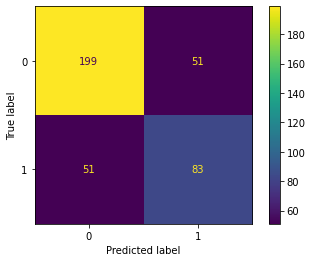

Improvement 1.153903066451125
near_miss1
Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



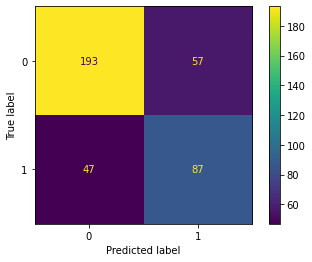

              precision    recall  f1-score   support

           0     0.7900    0.6920    0.7377       250
           1     0.5333    0.6567    0.5886       134

    accuracy                         0.6797       384
   macro avg     0.6616    0.6744    0.6632       384
weighted avg     0.7004    0.6797    0.6857       384



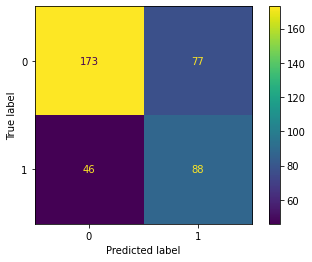

Improvement -16.957006170996923
near_miss2
Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



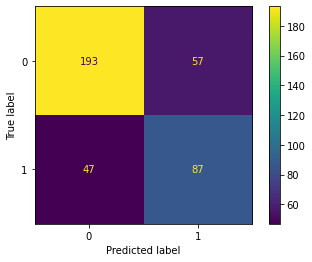

              precision    recall  f1-score   support

           0     0.7679    0.7280    0.7474       250
           1     0.5374    0.5896    0.5623       134

    accuracy                         0.6797       384
   macro avg     0.6527    0.6588    0.6549       384
weighted avg     0.6875    0.6797    0.6828       384



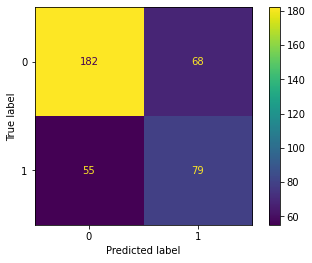

Improvement -18.030465331640237
random_sampler
Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



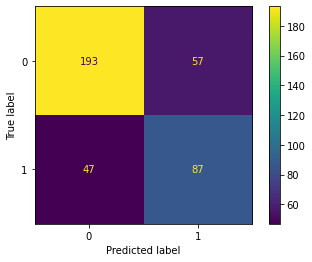

              precision    recall  f1-score   support

           0     0.7909    0.6960    0.7404       250
           1     0.5366    0.6567    0.5906       134

    accuracy                         0.6823       384
   macro avg     0.6637    0.6764    0.6655       384
weighted avg     0.7022    0.6823    0.6881       384



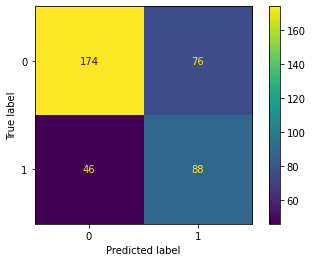

Improvement -16.0498505951066
cluster_centroids


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



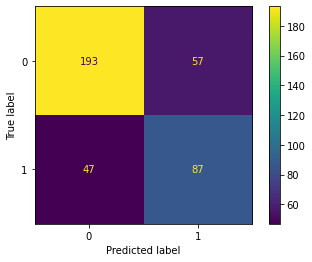

              precision    recall  f1-score   support

           0     0.8136    0.7160    0.7617       250
           1     0.5671    0.6940    0.6242       134

    accuracy                         0.7083       384
   macro avg     0.6904    0.7050    0.6929       384
weighted avg     0.7276    0.7083    0.7137       384



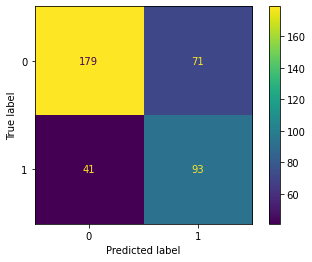

Improvement -6.537567759442138
cluster_centroids_est_k


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Old class balance ({1: 134}, {0: 250}, 384)
New class balance ({1: 134}, {0: 190}, 324)
Reduction ratio 15.625
              precision    recall  f1-score   support

           0     0.8042    0.7720    0.7878       250
           1     0.6042    0.6493    0.6259       134

    accuracy                         0.7292       384
   macro avg     0.7042    0.7106    0.7068       384
weighted avg     0.7344    0.7292    0.7313       384



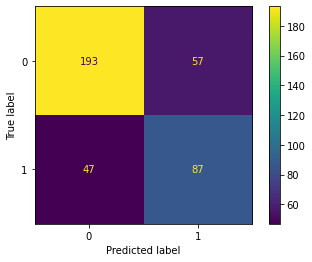

              precision    recall  f1-score   support

           0     0.7773    0.7400    0.7582       250
           1     0.5548    0.6045    0.5786       134

    accuracy                         0.6927       384
   macro avg     0.6661    0.6722    0.6684       384
weighted avg     0.6997    0.6927    0.6955       384



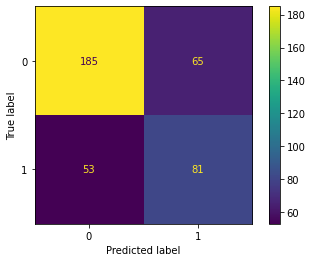

Improvement -13.306940035013392
    Dataset                   Method       Acc  Precision    Recall        F1  \
0  diabetes                 original  0.729167   0.734375  0.729167  0.731274   
1  diabetes               clustering  0.734375   0.734375  0.734375  0.734375   
2  diabetes               near_miss1  0.679688   0.700404  0.679688  0.685706   
3  diabetes               near_miss2  0.679688   0.687491  0.679688  0.682822   
4  diabetes           random_sampler  0.682292   0.702161  0.682292  0.688144   
5  diabetes        cluster_centroids  0.708333   0.727596  0.708333  0.713706   
6  diabetes  cluster_centroids_est_k  0.692708   0.699662  0.692708  0.695515   

        Impr  Support  
0   0.000000  134,250  
1   1.153903  134,190  
2 -16.957006  134,190  
3 -18.030465  134,190  
4 -16.049851  134,190  
5  -6.537568  134,190  
6 -13.306940  134,190  


In [ ]:
names=["diabetes.csv"]#,"abalone.csv","vowel.csv","ionosphere.csv","vehicle.csv"]

use_case="Adasyn"
label="Class"
class_values=(1,0)
overall_result=pd.DataFrame()
for name in names:
  train_data=Modifier(f"/content/drive/My Drive/Cluster/{use_case}/{name}",label,use_case,class_values)
  train_data.load()
  print(name)
  print(train_data.class_balance(train_data.csv_data[label]))
  #print(train_data.csv_data)
  print()
  clf=DecisionTreeClassifier(random_state=42)
  X_train, X_test, y_train, y_test = train_test_split(train_data.get_all_features(), train_data.get_all_label(), test_size=0.5, random_state=42, shuffle=True, stratify=train_data.get_all_label())
  clf.fit(X_train,y_train)
  pred = clf.predict(X_test)
  original_result=classification_report(y_test,pred,digits=4,output_dict=True)
  train_data.cnt_new=train_data.class_balance(y_train)
  tmp=train_data.prepare_model_result(original_result,'original',name[:-4])
  overall_result=pd.concat([overall_result,tmp])
  # metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, pred)).plot()
  # plt.show()
  train_data.set_data(pd.concat([X_train,y_train],axis=1))
  test_data=Dataset(_,label,use_case,class_values)
  test_data.set_data(pd.concat([X_test,y_test],axis=1))

  # just small sample to train classifier
  dumb_X_train, _, dumb_y_train, _ = train_test_split(train_data.get_all_features(), train_data.get_all_label(), test_size=0.8, random_state=42, shuffle=True, stratify=train_data.get_all_label())
  clf_dumb=DecisionTreeClassifier(random_state=42)
  clf_dumb.fit(dumb_X_train, dumb_y_train)

  cluster_model=Sklearn_model(train_data,clf_dumb,0)
  cluster_model.cluster_analysis(pca=True)
  train_data.reduce(cluster_model,1/cluster_model.size)
  train_data.set_class(1)
  minority_data=pd.concat([train_data.X,train_data.y],axis=1)
  train_data.newdata=pd.concat([train_data.newdata,minority_data])
  clf_new=DecisionTreeClassifier(random_state=42)
  clustered_result=train_data.compare_models(clf,clf_new,test_data)
  tmp=train_data.prepare_model_result(clustered_result,'clustering',name[:-4])
  overall_result=pd.concat([overall_result,tmp])

  balance=train_data.class_balance(train_data.newdata[train_data.label].reset_index(drop=True))
  sampling_ratio=balance[0][1]/balance[1][0]
  balance_dict={0:balance[1][0],1:balance[0][1]}
  imbl=[(NearMiss(sampling_strategy=balance_dict,version=1),"near_miss1"),#
        (NearMiss(sampling_strategy=sampling_ratio,version=2),"near_miss2"),
        #(NearMiss(sampling_strategy=sampling_ratio,version=3),"near_miss3"),
        # (CondensedNearestNeighbour(random_state=42),"condensed_NN"),
        # (EditedNearestNeighbours(),"edited_NN"),
        # (RepeatedEditedNearestNeighbours(),"rep_edited__NN"),
        # (InstanceHardnessThreshold(sampling_strategy=sampling_ratio,random_state=42),"inst_hard_tresh"),
        # (NeighbourhoodCleaningRule(),"neigh_clean_rule"),
        (RandomUnderSampler(sampling_strategy=sampling_ratio,random_state=42),"random_sampler"),
        # (TomekLinks(),"tomek_links"),
        (ClusterCentroids(sampling_strategy=sampling_ratio,random_state=42),"cluster_centroids"),
        (ClusterCentroids(sampling_strategy=sampling_ratio,random_state=42,estimator=KMeans(n_clusters=cluster_model.size)),"cluster_centroids_est_k")
        ]
  for sampler in imbl:
    print(sampler[1])
    train_data.apply_imbalanced_lib(sampler[0])
    imbl_result=train_data.compare_models(clf,clf_new,test_data)
    tmp=train_data.prepare_model_result(imbl_result,sampler[1],name[:-4])
    overall_result=pd.concat([overall_result,tmp])

overall_result.reset_index(inplace=True,drop=True)
print(overall_result)


In [ ]:
overall_result.to_csv(f"/content/drive/My Drive/Cluster/{use_case}/comparation.csv",index=False)

In [ ]:
overall_result

,Dataset,Method,Acc,Precision,Recall,F1,Impr,Support
0,diabetes,original,0.729167,0.734375,0.729167,0.731274,0.000000,"134,250"
1,diabetes,clustering,0.718750,0.726516,0.718750,0.721680,-3.570073,"134,226"
2,diabetes,near_miss1,0.731771,0.737518,0.731771,0.734042,1.029841,"134,226"
3,diabetes,near_miss2,0.687500,0.694536,0.687500,0.690354,-15.227397,"134,226"
4,diabetes,random_sampler,0.747396,0.751803,0.747396,0.749184,6.664874,"134,226"
5,diabetes,cluster_centroids,0.716146,0.732916,0.716146,0.721034,-3.810553,"134,226"
6,diabetes,cluster_centroids_est_k,0.729167,0.730125,0.729167,0.729626,-0.613359,"134,226"
7,abalone,original,0.926230,0.931065,0.926230,0.928527,0.000000,"21,344"
8,abalone,clustering,0.920765,0.922517,0.920765,0.921629,-9.652083,"21,300"
9,abalone,near_miss1,0.846995,0.916227,0.846995,0.876356,-72.994675,"21,299"


# DGA data

In [ ]:
dga_test_analyze="/content/drive/My Drive/Cluster/DGA/dga_test_analyze.csv"
label="class"
use_case="DGA"
class_values=("dga","legit")
class_number=1
drop=["domain"]
Data=Dataset(dga_test_analyze,label,use_case,class_values,drop)
Data.load()
print(Data.csv_data)

In [ ]:
classifier=load(f"/content/drive/My Drive/Cluster/DGA/is_dga_old.model")

old_data_path = f"/content/drive/My Drive/Cluster/{use_case}/dga_train_sampled.csv"
old_data=Modifier(old_data_path, label,use_case,class_values,drop)
old_data.load()

In [ ]:
pos_clustering_sklearn=Sklearn_model(Data,classifier,class_number)
pos_clustering_sklearn.cluster_analysis()

In [ ]:
neg_clustering_sklearn=Sklearn_model(Data,classifier,1-class_number)
neg_clustering_sklearn.cluster_analysis()

In [ ]:
old_data.reduce(pos_clustering_sklearn)
old_data.newdata

In [ ]:
old_data.reduce(neg_clustering_sklearn)
old_data.newdata

In [ ]:
pos_clustering_model=H2O_model(Data,classifier,class_number)
pos_clustering_model.cluster_analysis()

In [ ]:
old_data.reduce(pos_clustering_model)
old_data.newdata

In [ ]:
neg_clustering_model=H2O_model(Data,classifier,1-class_number)
neg_clustering_model.cluster_analysis()

In [ ]:
old_data.reduce(neg_clustering_model)
old_data.newdata

In [ ]:
classifier_new= DecisionTreeClassifier(criterion="entropy",random_state=42, max_depth=17)
#old_data.compare_models(classifier,classifier_new,Data)

In [ ]:
#sampler = RandomUnderSampler(sampling_strategy="all",random_state=42)
sampler = NearMiss(sampling_strategy="all",n_jobs=-1)  
old_data.apply_imbalanced_lib(sampler)
old_data.compare_models(classifier,classifier_new,Data)

In [ ]:
tmp=old_data.newdata

old_data.update_csv()

h2o.download_all_logs(dirname="/content/drive/My Drive/Cluster/log/", filename = 'autoh2o_log.zip')

# Old code

In [ ]:
#@title
# read input dataset for clustering 
#input= sys.argv[1]
sample_data = "/content/drive/My Drive/Cluster/sample_data.csv"
doh_paper= "/content/drive/My Drive/Cluster/doh_paper.csv"
new_data = "/content/drive/My Drive/Cluster/generated_data.csv"
real_data = "/content/drive/My Drive/Cluster/new_real.csv"
dga_data = "/content/drive/My Drive/Cluster/dga_only_test.csv"

dga_all_data = "/content/drive/My Drive/Cluster/3m_dga_1.48_reduced_features.csv"
doh_test_analyze="/content/drive/My Drive/Cluster/is_doh_test_analyze_3M.csv"
dga_test_analyze="/content/drive/My Drive/Cluster/dga_test_analyze.csv"

Data = pd.read_csv(dga_test_analyze)###
label="is_dga"
Data.rename(columns = {'class':label}, inplace = True)

flag=0
Data[label]=Data[label].apply(new_classes)

#Data[label]=1###!
#Data.rename(columns = {'class':'dga'}, inplace = True)
print(Data)
# filter data

label_data=Data[Data[label] == flag]

#final=Data.drop("domain")

# remove text column
#Data.pop('Dataset')
#Data.pop('domain') 
#Data.rename(columns={'metric_entropy':"met_ent"},inplace=True)

# convert to numpy and show data

y=label_data[label]
X=label_data.drop(columns=[label,"domain"]) ###is_doh
feature_cnt=X.shape[1]
sample_np=X.to_numpy()
X

In [ ]:
#@title
correlation_with_class=Data.drop(columns=[label]).corrwith(Data[label],method="spearman").reset_index()
correlation_with_class.columns=["atrr","corr"]
print(correlation_with_class)
corr_pos=correlation_with_class[correlation_with_class["corr"] >= 0.3]
corr_neg=correlation_with_class[correlation_with_class["corr"] <= -0.3]
#print(corr_pos)
#print(corr_neg)
atrr_correlation=pd.concat([corr_pos,corr_neg],axis=0).reset_index(drop=True)
print(atrr_correlation)
#atrr_correlation.to_csv('/content/drive/My Drive/Cluster/correlation_dga.txt',header=False)

In [ ]:
#@title

class_corr=atrr_correlation ###is_doh
pos_corr=list(class_corr[class_corr["corr"]>0]["atrr"])
neg_corr=list(class_corr[class_corr["corr"]<0]["atrr"])
corr_pairs=list(itertools.product(pos_corr,neg_corr))+list(itertools.product(neg_corr,pos_corr))
corr_pairs

In [ ]:
#@title
h2o.init()
# create h2o data frame
sample = h2o.H2OFrame(sample_np)

Train model

In [ ]:
#@title
# model inicializaton
model=H2OKMeansEstimator(  k=10,
                                estimate_k=True,
                                standardize=True,
                                seed=1234,
                                max_iterations = 100)

# create model for kmeans algorithm
model.train(training_frame=sample)

# show some model metrics
print(model.model_performance())


Load or save existing model

---



---



In [ ]:
#@title
h2o.save_model(model=model, path="/content/drive/My Drive/Cluster/", force=True)
# model=h2o.load_model("/content/drive/My Drive/Cluster/kmeans_model")

In [ ]:
#@title
# apply kmeans to our dataset
result=model.predict(sample)
print(result)

In [ ]:
#@title
############################################################# show report on clustered dataset #############################################################

# number of created clusters
number_of_clusters=len(model.size())

# clustered data from h2o frame to pandas data frame
data_as_df = result.as_data_frame(use_pandas=True, header=True)

# init dictionary for individual clusters
clusters={}
report={}
for x in range(0,number_of_clusters):
    clusters['cluster{0}'.format(x)]=[]
    report['cluster{0}'.format(x)]={}

# insert clustered data to predicted cluster
for i,data in enumerate(sample_np):
    clusters['cluster{0}'.format(data_as_df.values[i][0])].append(data)


In [ ]:
#@title
# load model 
aclf_classifier_old=load("/content/drive/My Drive/Cluster/is_doh_new+old.model")
# train=pd.read_csv('/content/drive/My Drive/Cluster/is_doh_train_old+new.csv')
# y_old = train['is_doh']
# X_old = train.drop(columns=['is_doh'])

# aclf_classifier_old = AdaBoostClassifier(
#     base_estimator=DecisionTreeClassifier(
#         max_depth=6,
#         criterion='entropy',
#         max_features=None
#     ),
#     n_estimators=25,
#     algorithm='SAMME.R'
# )
# aclf_classifier_old.fit(X_old, y_old)

pred = aclf_classifier_old.predict(X)#Data.drop(columns=['is_doh']))
print(classification_report(y,pred))#Data["is_doh"], pred))
total_acc=metrics.accuracy_score(y,pred)
metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) ).plot();
total_acc

In [ ]:
#@title
classifier=load(f"/content/drive/My Drive/Cluster/{label}_old.model")

# train=pd.read_csv('/content/drive/My Drive/Cluster/dga_train_sampled.csv')
# train.rename(columns = {'class':label}, inplace = True)
# train[label]=train[label].apply(new_classes)

# y_old = train[label]
# X_old = train.drop(columns=[label,"domain"])
# classifier = DecisionTreeClassifier(criterion="entropy",random_state=42, max_depth=17)
# classifier.fit(X_old, y_old)

pred=classifier.predict(X)
print(classification_report(y,pred))#Data["is_doh"], pred))
total_acc=metrics.accuracy_score(y,pred)
metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) ).plot();
total_acc

In [ ]:
#@title
clf=classifier

In [ ]:
#@title
# save model

dump(clf, f"/content/drive/My Drive/Cluster/{label}_old.model")

In [ ]:
#@title
from pandas._libs.algos import diff_2d
s = pd.Series([flag])

# dataframe for heatmap
heatmap=pd.DataFrame()

for cluster in clusters:
    # number of cluster
    print(color.BOLD + color.RED+ cluster+ color.END)

    # dataframe for effective metrics computation
    df=pd.DataFrame(clusters[cluster],columns=X.columns)
    
    # classify cluster
    
    pred = clf.predict(df)
    y_gen = s.repeat(len(clusters[cluster]))
    print(classification_report(y_gen, pred))
    print(metrics.confusion_matrix(y_gen, pred))
    report[cluster]["acc"]=metrics.accuracy_score(y_gen,pred)
    #metrics.ConfusionMatrixDisplay( metrics.confusion_matrix(y, pred) ).plot();
    

    # variance of features
    print(color.BOLD +color.BLUE+'\nVariance of features:'+ color.END)
    print(df.var().sort_values().to_string())

    # average of features
    print(color.BOLD +color.BLUE+'\nAverage of features:'+ color.END)
    mean=df.mean()
    original_mean=X.mean()
    out=mean.sort_values()
    print(out.to_string())
    
    # average deviation of features
    diff=mean-original_mean
    # get maximal difference
    lower_min=abs(original_mean-X.min())
    lower_max=abs(original_mean-X.max())

    for i,value in diff.iteritems():
        if value < 0:
            diff.at[i]=value/lower_min[i]*100
        else:
            diff.at[i]=value/lower_max[i]*100

    print(color.BOLD +color.BLUE+'\nAverage deviation of features (%):'+ color.END)
    diff = diff.sort_values().dropna()
    out=diff
    print(out.to_string())
    report[cluster]["dev"]=out
    heatmap=pd.concat([heatmap,diff.rename(cluster)],axis=1)
    
    # correlation of features
    print(color.BOLD +color.BLUE+'\nCorrelation of features:'+ color.END)
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    out=df.corr(method='spearman').unstack().drop(labels=pairs_to_drop).sort_values().dropna()
    print(out.to_string())
    report[cluster]["corr"]=out

    # size of cluster
    print(color.BOLD + color.BLUE+'\nSize of cluster:'+ color.END)
    size=len(clusters[cluster])
    report[cluster]["size"]=size
    print(size,'\n')

Hard cluster score computation

In [ ]:
#@title
accs=list(map(lambda x: x[1]["acc"],list(report.items())))
max_acc=max(accs)
min_acc=min(accs)
accs

In [ ]:
#@title
#print(report['cluster0']["dev"])
acc_dev=[]
cluster_dev=[]
cluster_num=[]
chart=[]
amount=[]
red=[]
for cluster in report:
  
  dev=report[cluster]["dev"]
  corr=report[cluster]["corr"]
  
  # for later
  print(cluster)
  cnt=feature_cnt//3
  dev_neg=dev.head(cnt)
  dev_pos=dev.tail(cnt)
  dev_pos=dev_pos[lambda x: x<-50]
  dev_neg=dev_neg[lambda x: x>50]

  # amount of data in cluster
  amount_ratio=report[cluster]["size"]/X.shape[0]*100
  inv_amount_ratio=100-amount_ratio
  print("inv_amount ratio",inv_amount_ratio)


  # pick up most deviated clusters 
  extreme_deviation=dev[lambda x: (x < -50) | (x > 50)]
  if extreme_deviation.empty:
    mean_deviation=0
  else:
    abs_dev=extreme_deviation.abs()
    mean_deviation=abs_dev.mean()
  
  print("average deviation",mean_deviation)

  extreme_deviation_cnt=len(extreme_deviation)
  ratio_extreme_deviation=extreme_deviation_cnt/len(dev)*100
  
  print("ratio of extreme deviation",ratio_extreme_deviation)
  cluster_dev.append(extreme_deviation_cnt)
  
  

  # check if negativly correlated attrr are adversarial
  corr_pos=corr[lambda x: x >= 0.75]
  corr_neg=corr[lambda x: x <= -0.3]
  adversial_distance=0
  corr_cnt=0
  if not corr_neg.empty:
    #print(corr_neg)
    for corr in corr_neg.index:
      if corr in corr_pairs:
        corr_cnt+=1
        #print(corr)
        first = corr[0]
        second = corr[1]
        #print(first,second)
        adversial_distance+=abs(dev[first]-dev[second])
    if corr_cnt != 0:
      adversial_distance/=corr_cnt*2
      adversial_distance=100-adversial_distance
  
  print("adversarial distance",adversial_distance)
  
  #similarity to another class
  
  neg_attr=list(class_corr[class_corr["corr"]<0]["atrr"])
  pos_attr=list(class_corr[class_corr["corr"]>0]["atrr"])
  #print(neg_attr,pos_attr)
  sim_neg=0
  sim_pos=0

  for attr in neg_attr:
    sim_neg+=dev[attr]
  if len(neg_attr) != 0:
    sim_neg=(sim_neg/len(neg_attr)+100)/2
  
  
  for attr in pos_attr:
      sim_pos+=dev[attr]
  if len(pos_attr) != 0:
    sim_pos=(sim_pos/len(pos_attr)+100)/2
  

  if flag:
    sim_pos=100-sim_pos
  else:
    sim_neg=100-sim_neg
  sim=(sim_neg+sim_pos)/2
  print("similarity",sim)
  
  
  relative_deviation_acc=report[cluster]["acc"]-total_acc
 
  if relative_deviation_acc < 0:
      acc_ratio=((relative_deviation_acc/abs(min_acc-total_acc)*(-100))+100)/2
  else:
      acc_ratio=((relative_deviation_acc/abs(max_acc-total_acc)*(-100))+100)/2
  
  print("relative deviation of model acc",acc_ratio,relative_deviation_acc,total_acc,report[cluster]["acc"])
  acc_dev.append(acc_ratio)
  

  # make one metrics, always percenatge, complement of acc, maybe normalize to 0,1 by averaging
  cluster_metric=(mean_deviation+ratio_extreme_deviation+adversial_distance+inv_amount_ratio+sim+acc_ratio)/6
  

  # reduction candidate
  reduction_threshold=100/number_of_clusters*1.9
  if amount_ratio > reduction_threshold and cluster_metric < 60:
    report[cluster]['red']=1
    print("reduction candidate",amount_ratio,reduction_threshold)
  else:
    report[cluster]['red']=0
  
  print("FINAL",cluster_metric)
  #chart.append((cluster_metric,report[cluster]["acc"],report[cluster]["red"]))
  chart.append(cluster_metric)
  amount.append(amount_ratio)
  red.append(report[cluster]['red'])
  cluster_num.append(cluster)
print(chart)

score_data=pd.DataFrame({"skore":chart,"podil dat":amount,"redukce":red,"inv_acc":acc_dev})




In [ ]:
#@title
ax=score_data.plot.bar(figsize=(9,7))
ax.set(xlabel='Shluky', ylabel='Hodnota (%)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
fig=ax.get_figure()
plt.show()
plt.clf()
ax=sns.regplot(x="skore",y="inv_acc",data=score_data,ci=None)
# fig.savefig(f"/content/drive/My Drive/Cluster/score_chart_{label}_{flag}.pdf")

In [ ]:
#@title
temp=pd.Series(chart)
treshold=(2*temp.mean()+temp.max())/3
print(treshold)
print(reduction_threshold)

In [ ]:
#@title
print(acc_dev)
print(cluster_dev)
data_plot=pd.DataFrame({"acc":acc_dev,"dev":cluster_dev})
data_plot.sort_values("dev",inplace=True)
data_plot.drop_duplicates("dev",inplace=True)
print(data_plot)

plt.plot( 'dev', 'acc', data=data_plot, marker='o', color='mediumvioletred')
plt.show()
df=pd.DataFrame(chart,columns=["metric","acc","red"])
df.sort_values("metric",inplace=True)
print(df)

plt.plot( 'metric', 'acc', data=df, marker='o', color='mediumvioletred')

Save results

In [ ]:
#@title
output=score_data[score_data["skore"]>treshold].reset_index()["index"]
output=output.rename("augument")
reduction= score_data[score_data["redukce"]==1].reset_index()["index"]
reduction = reduction.rename("reduction")

output.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False)
reduction.to_csv(f'/content/drive/My Drive/Cluster/{label}_{flag}_result_2.0.txt',index=False,mode="a")

print(output,"--\n",reduction)


In [ ]:
#@title

data_enrichment=pd.read_csv(real_data)
doh_true=data_enrichment[data_enrichment["is_doh"]==True]
doh_true.pop("is_doh")
print(doh_true)

In [ ]:
#@title
converted=h2o.H2OFrame(doh_true)
clustered=model.predict(converted)
print(clustered)


In [ ]:
#@title
print(heatmap)
graph=sns.heatmap(heatmap,cmap="coolwarm", cbar_kws={"label":"[%]"})
graph.set(xlabel='Clusters', ylabel='Features')
graph.set_xticklabels(graph.get_xticklabels(), rotation=45)

# Data split

In [ ]:
#@title
# dga_data3m = "/content/drive/My Drive/Cluster/dga_train_dataset3M.csv"
# data_split=pd.read_csv(dga_data3m)

In [ ]:
#@title
# y=data_split["class"]
# X=data_split.drop(columns=["class"])
# X_Train, X_Test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=True, stratify=y)

In [ ]:
#@title
# tmp_data=pd.concat([X_Test,y_test],axis=1)

In [ ]:
#@title
# tmp_data

In [ ]:
#@title
# tmp_data.to_csv("/content/drive/My Drive/Cluster/dga_train_sampled.csv",index=False)

In [ ]:
#@title


# TODO
